In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white', font_scale=1)

import os
import scikit_posthocs as sp
from pybedtools import BedTool
import pybedtools
from upsetplot import plot, from_indicators
import pysam
import json
import re
import random


In [2]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level


#Wynton
BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

EXP_PATH = os.path.join(RESULTS_PATH, "expectedDiv")
# Local

# DATA_PATH = os.path.join(BASE_PATH, "../../../dowloads/")  # where I dump new data
# COMP_PATH = os.path.join(DATA_PATH,"1KGvsHSMRCA")

In [3]:
BASE_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome'

# Scatter plot by windows

In [4]:


# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
windows_to_keep = anc_div.index
anc_div = anc_div.dropna(axis=1)

anc = pd.read_table('%s/comp_tables/anc_genomewide_averages.csv' % RESULTS_PATH,
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman
windows_to_keep.to_frame(index=False).to_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH)

In [5]:
anc

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence
1KG,,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.000654,0.995720,AFR,ACB,female,HG01880,0.004280
AFR_ACB_female_HG01883,hsmrca_ancestral,0.000688,0.995387,AFR,ACB,female,HG01883,0.004613
AFR_ACB_female_HG01886,hsmrca_ancestral,0.000680,0.995517,AFR,ACB,female,HG01886,0.004483
AFR_ACB_female_HG01889,hsmrca_ancestral,0.000709,0.995272,AFR,ACB,female,HG01889,0.004728
AFR_ACB_female_HG01894,hsmrca_ancestral,0.000683,0.995589,AFR,ACB,female,HG01894,0.004411
...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.000642,0.995748,SAS,STU,male,HG04039,0.004252
SAS_STU_male_HG04100,hsmrca_ancestral,0.000664,0.995672,SAS,STU,male,HG04100,0.004328
SAS_STU_male_HG04107,hsmrca_ancestral,0.000671,0.995665,SAS,STU,male,HG04107,0.004335


In [6]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [7]:
anc_melt = anc_div.melt(ignore_index=False, value_name = 'anc_div', var_name=['super','sub','sex','id'])

Import and format sequence comparisons

In [8]:
seq_diff = pd.read_table('%s/comp_tables/anc_window_seq_diff.csv' % RESULTS_PATH, sep=',',
 header=[0,1,2,3], index_col=[0,1])
seq_diff = seq_diff.loc[anc_div.index][anc_div.columns]

In [9]:
seq_melt = seq_diff.melt(ignore_index=False, value_name = 'seq_diff', var_name=['super','sub','sex','id'])

In [10]:
genome_wide = pd.read_table('%s/comp_tables/anc_genomewide_averages_seq_fixingwyntonfuckup.csv' % RESULTS_PATH,
sep=',', index_col=0)
genome_wide['seq_diff'] = 1-genome_wide['seq_id']

In [11]:
genome_wide

,ancestor,seq_id,super_pop,sub_pop,sex,id,seq_diff
1KG,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.998409,AFR,ACB,female,HG01880,0.001591
AFR_ACB_female_HG01883,hsmrca_ancestral,0.998386,AFR,ACB,female,HG01883,0.001614
AFR_ACB_female_HG01886,hsmrca_ancestral,0.998377,AFR,ACB,female,HG01886,0.001623
AFR_ACB_female_HG01889,hsmrca_ancestral,0.998372,AFR,ACB,female,HG01889,0.001628
AFR_ACB_female_HG01894,hsmrca_ancestral,0.998384,AFR,ACB,female,HG01894,0.001616
...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.998478,SAS,STU,male,HG04039,0.001522
SAS_STU_male_HG04100,hsmrca_ancestral,0.998473,SAS,STU,male,HG04100,0.001527
SAS_STU_male_HG04107,hsmrca_ancestral,0.998479,SAS,STU,male,HG04107,0.001521


In [12]:
all_indivs_avgs = pd.DataFrame(index = seq_diff.index)
all_indivs_avgs['seq_diff'] = seq_diff.mean(axis=1)
all_indivs_avgs['3d_div'] = anc_div.mean(axis=1)

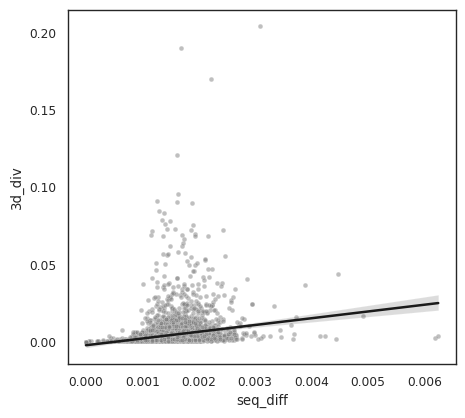

In [188]:
fig, ax = plt.subplots(figsize=(5,4.6))   
_ = sns.scatterplot(x='seq_diff', y='3d_div', data=all_indivs_avgs, s=12,alpha=0.5, color='grey')
_ = sns.regplot(data=all_indivs_avgs, y="3d_div", x="seq_diff", scatter=False, ax=ax,color='k')

In [189]:
all_melt = pd.concat([seq_melt, anc_melt.anc_div], axis=1)

In [190]:
all_melt

super  sub     sex       id  seq_diff   anc_div
chr   windowStartPos                                                
chr1  1048576          AFR  ACB  female  HG01880  0.002069  0.000982
      1572864          AFR  ACB  female  HG01880  0.001890  0.001445
      3145728          AFR  ACB  female  HG01880  0.002227  0.001283
      3670016          AFR  ACB  female  HG01880  0.002389  0.005119
      4194304          AFR  ACB  female  HG01880  0.002138  0.008681
...                    ...  ...     ...      ...       ...       ...
chr22 46661632         SAS  STU    male  HG04229  0.002056  0.002893
      47185920         SAS  STU    male  HG04229  0.002043  0.005283
      47710208         SAS  STU    male  HG04229  0.002489  0.045514
      48234496         SAS  STU    male  HG04229  0.003124  0.183812
      48758784         SAS  STU    male  HG04229  0.002911  0.005613

[11958342 rows x 6 columns]

In [74]:
# fig, ax = plt.subplots(figsize=(5,4.6))   
# _ = sns.scatterplot(x='seq_diff', y='anc_div', data=all_melt, s=12,alpha=0.5)
# _ = sns.regplot(data=all_melt, y="anc_div", x="seq_diff", scatter=False, ax=ax,color='k')

In [75]:
# fig, ax = plt.subplots(figsize=(4.6,1))  
# sns.kdeplot(all_melt[all_melt.anc_div<=0.05]['anc_div'], ax=ax)

In [76]:
# all_melt['anc_div'].plot.kde(color='navy',ax=ax)

In [77]:
xdata, ydata = all_melt["seq_diff"], all_melt["anc_div"]

<AxesSubplot: xlabel='seq_diff', ylabel='anc_div'>

/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


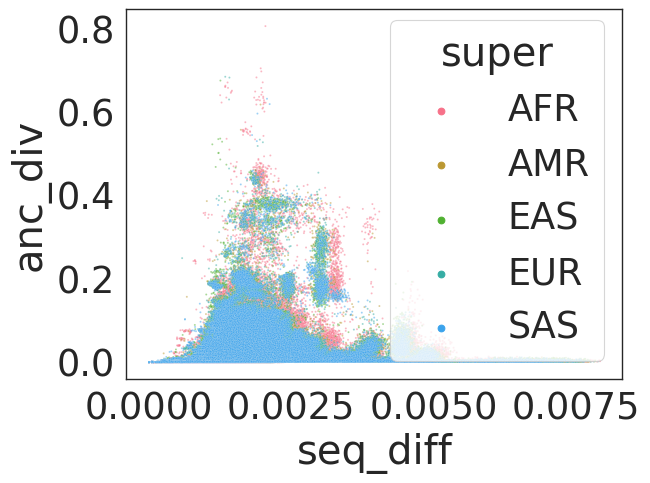

In [78]:
sns.scatterplot(x='seq_diff', y='anc_div', data=all_melt, s=2,alpha=0.5, hue = 'super')

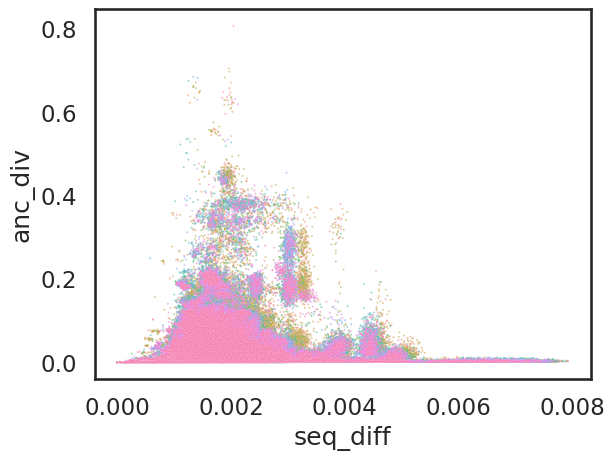

In [22]:
sns.scatterplot(x='seq_diff', y='anc_div', data=all_melt, s=2,alpha=0.5, hue = 'sub')
plt.legend('',frameon=False)

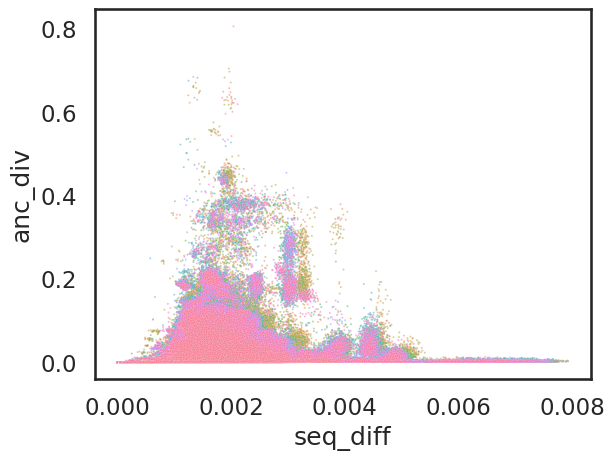

In [23]:
sns.scatterplot(x='seq_diff', y='anc_div', data=all_melt, s=2,alpha=0.5, hue = 'id')
plt.legend('',frameon=False)

In [24]:
all_melt.reset_index()

,chr,windowStartPos,super,sub,sex,id,seq_diff,anc_div
0,chr1,1048576,AFR,ACB,female,HG01880,0.002069,0.000982
1,chr1,1572864,AFR,ACB,female,HG01880,0.001890,0.001445
2,chr1,3145728,AFR,ACB,female,HG01880,0.002227,0.001283
3,chr1,3670016,AFR,ACB,female,HG01880,0.002389,0.005119
4,chr1,4194304,AFR,ACB,female,HG01880,0.002138,0.008681
...,...,...,...,...,...,...,...,...
11958337,chr22,46661632,SAS,STU,male,HG04229,0.002056,0.002893
11958338,chr22,47185920,SAS,STU,male,HG04229,0.002043,0.005283
11958339,chr22,47710208,SAS,STU,male,HG04229,0.002489,0.045514
11958340,chr22,48234496,SAS,STU,male,HG04229,0.003124,0.183812


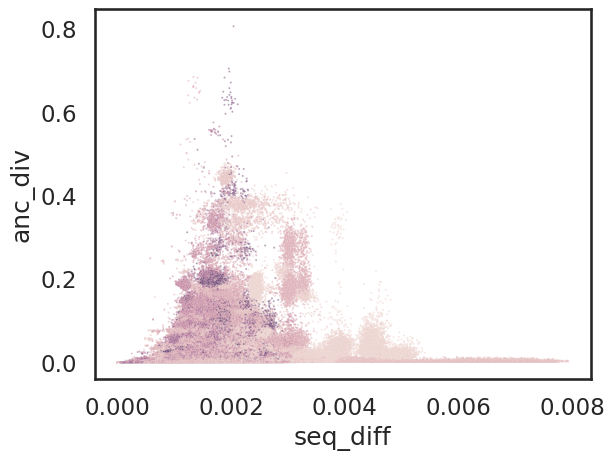

In [25]:
sns.scatterplot(x='seq_diff', y='anc_div', data=all_melt.reset_index(), s=2,alpha=0.5, hue = 'windowStartPos')
plt.legend('',frameon=False)

(0.015, 0.4)

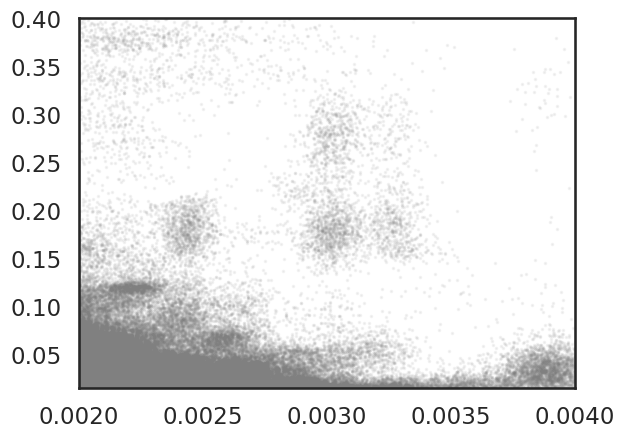

In [18]:
plt.scatter(xdata.values, ydata.values, color='grey', s=1, alpha = 0.1)
plt.xlim(0.002, 0.004)
plt.ylim(0.015, 0.4)

Text(0, 0.5, '3D Divergence')

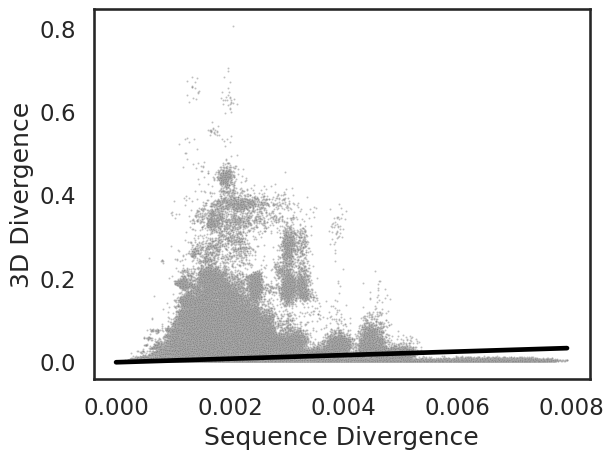

In [28]:
sns.scatterplot(x=xdata.values, y=ydata.values, color='grey', s=2, alpha = 0.5)
sns.regplot(x=xdata.values, y=ydata.values, scatter=False, color='black')
plt.xlabel('Sequence Divergence')
plt.ylabel('3D Divergence')

In [22]:
slope, intercept, r, p, se = stats.linregress(xdata.values, ydata.values)

In [23]:
stats.linregress(xdata.values, ydata.values)

LinregressResult(slope=4.291507484147253, intercept=-0.0022768724932120746, rvalue=0.13814922400785568, pvalue=0.0, stderr=0.008896959583381811, intercept_stderr=1.420949440792143e-05)

In [29]:
0.13814922400785568 **2

0.019085208093972687

In [24]:
stats.linregress(xdata.values, ydata.values)

LinregressResult(slope=4.291507484147253, intercept=-0.0022768724932120746, rvalue=0.13814922400785568, pvalue=0.0, stderr=0.008896959583381811, intercept_stderr=1.420949440792143e-05)

KeyboardInterrupt: 

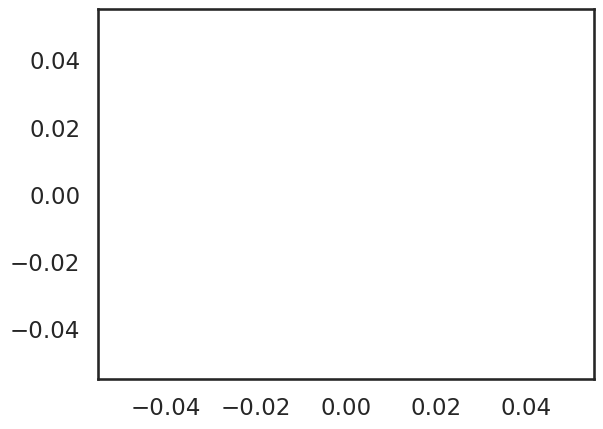

In [25]:
sns.regplot(x=xdata.values, y=ydata.values, scatter=False)

### Genome chunks dictionary to pickle

In [ ]:
chunks = dict.fromkeys(windows_to_keep.get_level_values(0).unique())

In [ ]:
for chrm in chunks.keys():
    chunks[chrm] = list(all_indivs_avgs.loc[chrm].index)

In [ ]:
chunks

{'chr1': [1048576,
  1572864,
  3145728,
  3670016,
  4194304,
  4718592,
  5242880,
  5767168,
  6291456,
  6815744,
  7340032,
  7864320,
  8388608,
  8912896,
  9437184,
  9961472,
  10485760,
  11010048,
  11534336,
  13107200,
  13631488,
  14155776,
  14680064,
  15204352,
  15728640,
  17301504,
  17825792,
  18350080,
  18874368,
  19398656,
  19922944,
  20447232,
  20971520,
  21495808,
  22020096,
  22544384,
  23068672,
  23592960,
  24117248,
  24641536,
  25165824,
  25690112,
  26214400,
  26738688,
  27262976,
  27787264,
  28311552,
  29884416,
  30408704,
  30932992,
  31457280,
  31981568,
  32505856,
  33030144,
  33554432,
  34078720,
  34603008,
  35127296,
  35651584,
  36175872,
  36700160,
  37224448,
  37748736,
  38273024,
  38797312,
  39321600,
  39845888,
  40370176,
  40894464,
  41418752,
  41943040,
  42467328,
  42991616,
  43515904,
  44040192,
  44564480,
  45088768,
  45613056,
  46137344,
  46661632,
  47185920,
  47710208,
  48234496,
  48758784,


In [ ]:
DATA_PATH+'/reference'

'/wynton/group/capra/projects/modern_human_3Dgenome/data/reference'

In [ ]:
import pickle

In [ ]:
pickle.dump( chunks, open( "%s/reference/genome_chunks_dict.p" % DATA_PATH, "wb" ) )

# Explore expected distributions

In [13]:
lst = list(range(1,101))
cols = ['chr','start_pos','num_diffs']+lst
chrms = [str(i) for i in list(range(1,23))]
inds = {'AFR':'AFR_ESN_female_HG03105', 'AMR':'AMR_CLM_female_HG01119', 'EUR':'EUR_CEU_female_NA06985', 'EAS':'EAS_CDX_female_HG00759', 'SAS':'SAS_BEB_female_HG03007'}
eDists = dict.fromkeys(inds.keys())

In [14]:
for pop in eDists.keys():
    print(pop)
    ind = inds[pop]
    pop_df = pd.DataFrame()
    for chrm in chrms:
        filename = "%s/%s/%s_chr%s_empiricDist.tsv"% (EXP_PATH, pop, ind, chrm)
        df = pd.read_table(filename, header=None, names=cols, index_col=[0,1])
        pop_df = pd.concat([pop_df, df])
    eDists[pop] = pop_df

AFR
AMR
EUR
EAS
SAS


In [15]:
num_diffs = pd.concat(
        [eDists['AFR']['num_diffs'], 
         eDists['AMR']['num_diffs'],
         eDists['EUR']['num_diffs'],
         eDists['EAS']['num_diffs'],
         eDists['SAS']['num_diffs']
         ],
        axis = 1, ignore_index=True)
num_diffs.columns = ['AFR','EUR','EAS','SAS','AMR']
eDists_all = pd.concat(
        [eDists['AFR'].drop(columns=['num_diffs']), 
         eDists['EUR'].drop(columns=['num_diffs']),
         eDists['EAS'].drop(columns=['num_diffs']),
         eDists['SAS'].drop(columns=['num_diffs']),
         eDists['AMR'].drop(columns=['num_diffs'])
         ], 
        axis=1, ignore_index=True).fillna(0)
eDists = pd.concat([num_diffs, eDists_all], axis = 1)

(0.0, 4000.0)

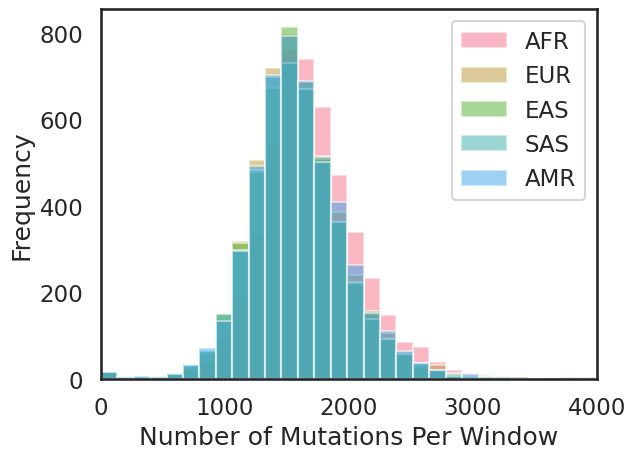

In [16]:
num_diffs.plot.hist(bins=50, alpha=0.5)
plt.xlabel('Number of Mutations Per Window')
plt.xlim(0,4000)


In [17]:
anc_div_summary = pd.DataFrame()
anc_div_summary['ALL'] = anc_div.mean(axis=1)
anc_div_summary['AFR'] = anc_div['AFR'].mean(axis=1)
anc_div_summary['EUR'] = anc_div['EUR'].mean(axis=1)
anc_div_summary['EAS'] = anc_div['EAS'].mean(axis=1)
anc_div_summary['SAS'] = anc_div['SAS'].mean(axis=1)
anc_div_summary['AMR'] = anc_div['AMR'].mean(axis=1)
anc_div_summary['min'] = anc_div.min(axis=1)
anc_div_summary['max'] = anc_div.max(axis=1)

anc_div_summary['emp_min'] = eDists_all.min(axis=1)
anc_div_summary['emp_max'] = eDists_all.max(axis=1)
eDists['mean'] = eDists_all.mean(axis=1)

In [18]:
eDists_all.index

MultiIndex([( 'chr1',  1048576),
            ( 'chr1',  1572864),
            ( 'chr1',  3145728),
            ( 'chr1',  3670016),
            ( 'chr1',  4194304),
            ( 'chr1',  4718592),
            ( 'chr1',  5242880),
            ( 'chr1',  5767168),
            ( 'chr1',  6291456),
            ( 'chr1',  6815744),
            ...
            ('chr22', 44040192),
            ('chr22', 44564480),
            ('chr22', 45088768),
            ('chr22', 45613056),
            ('chr22', 46137344),
            ('chr22', 46661632),
            ('chr22', 47185920),
            ('chr22', 47710208),
            ('chr22', 48234496),
            ('chr22', 48758784)],
           names=['chr', 'start_pos'], length=4873)

In [19]:
eDists_all.loc['chr1',0:99]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
start_pos,,,,,,,,,,,,,,,,,,,,,
1048576,0.002750,0.018778,0.002220,0.002877,0.004057,0.008035,0.006177,0.002887,0.037779,0.001301,...,0.001042,0.001589,0.003917,0.005275,0.002991,0.007975,0.000815,0.002143,0.004430,0.002073
1572864,0.003038,0.045816,0.010242,0.001534,0.050068,0.018466,0.004656,0.003538,0.026035,0.009492,...,0.002183,0.001858,0.004147,0.001313,0.003115,0.003329,0.014584,0.004588,0.001270,0.007137
3145728,0.002392,0.001234,0.002069,0.005067,0.046430,0.000956,0.001040,0.000703,0.001243,0.000806,...,0.000775,0.002339,0.000671,0.012412,0.001440,0.002751,0.001606,0.000839,0.000892,0.001088
3670016,0.018037,0.005422,0.021796,0.011557,0.004166,0.002329,0.018448,0.019690,0.003195,0.018402,...,0.000853,0.036392,0.003505,0.002780,0.001539,0.001445,0.000830,0.067980,0.003604,0.002799
4194304,0.013594,0.002850,0.134349,0.007526,0.005112,0.002033,0.008276,0.003338,0.029983,0.003348,...,0.017464,0.036657,0.016137,0.003086,0.032773,0.003978,0.003447,0.002185,0.001898,0.011999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245366784,0.022174,0.003142,0.010939,0.064908,0.015431,0.052582,0.002853,0.001149,0.002284,0.003898,...,0.001788,0.006397,0.002811,0.002777,0.027714,0.002465,0.002587,0.008745,0.000989,0.002189
245891072,0.014226,0.001194,0.002606,0.007143,0.001902,0.015049,0.003163,0.001221,0.000898,0.004573,...,0.001025,0.004152,0.004186,0.004348,0.002025,0.001401,0.028608,0.002040,0.019451,0.005088
246415360,0.002401,0.007518,0.018062,0.011446,0.023659,0.003288,0.023584,0.001689,0.003930,0.014390,...,0.010524,0.003973,0.006567,0.007605,0.009269,0.005395,0.012516,0.004640,0.024635,0.002252


## Plot mean obs vs mean expected

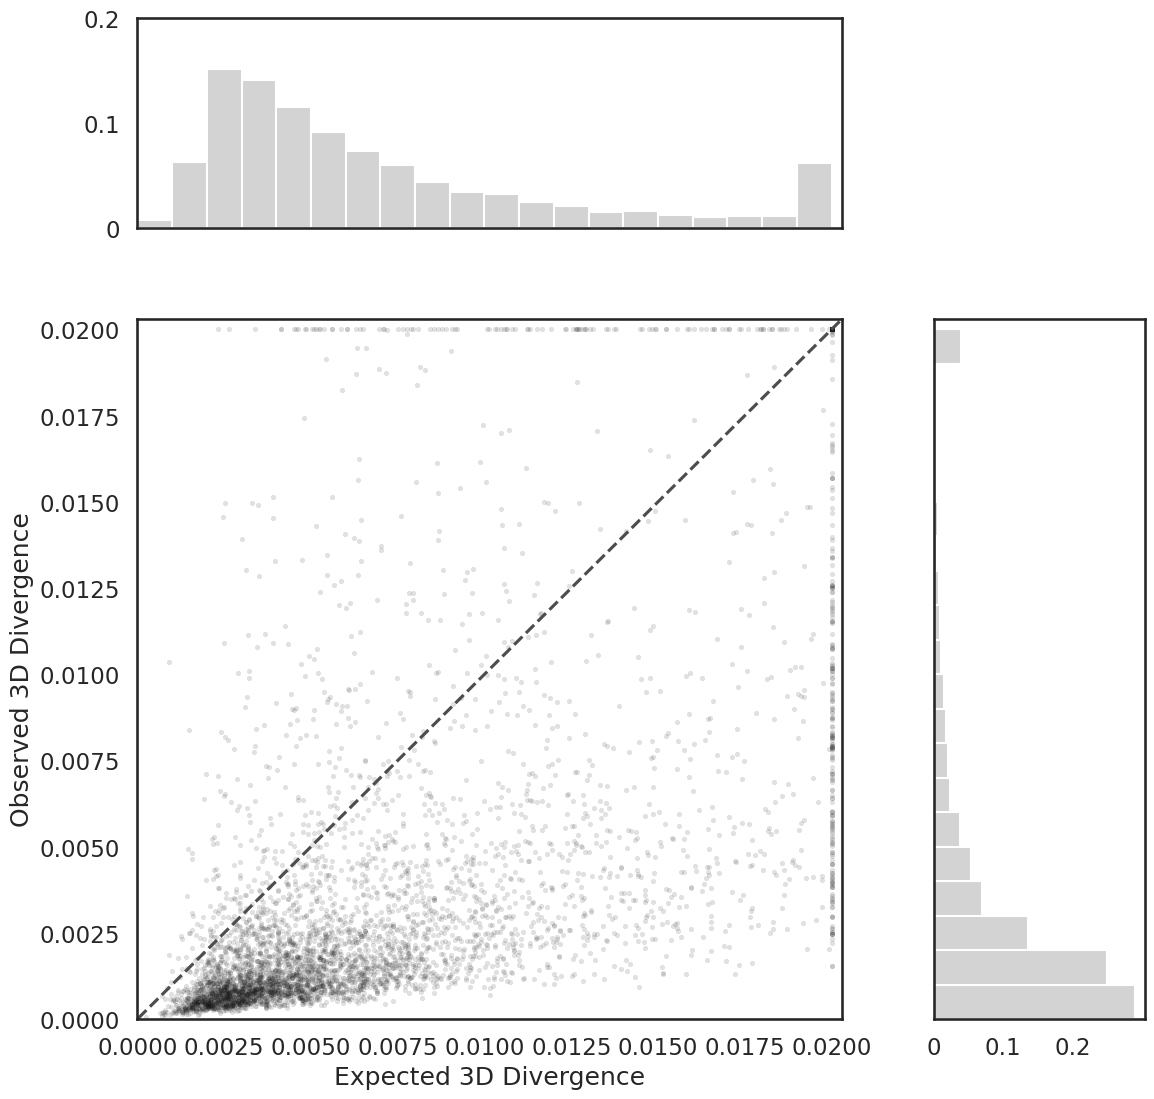

In [23]:
empiric = anc_div.mean(axis=1).reset_index(name='3D_divergence')
empiric['numMuts'] = num_diffs.mean(axis=1).values
empiric['meanExpected3Ddivergence'] = eDists['mean'].values

# Without color
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(13,13),gridspec_kw={'width_ratios': [5, 1.5], 'height_ratios': [1.5, 5]})         # Sample figsize in inches
empiric_clipped = empiric.copy(deep=True)
empiric_clipped['3D_divergence'] = empiric_clipped['3D_divergence'].clip(0,0.02)
empiric_clipped['meanExpected3Ddivergence'] = empiric_clipped['meanExpected3Ddivergence'].clip(0,0.02)

g = sns.scatterplot(y="3D_divergence", x="meanExpected3Ddivergence", s=12,alpha=0.13,data=empiric_clipped,ax=ax[1,0], color='k',linewidth=.15, edgecolor='k',)#, x_bins=np.arange(0.9965,1,0.00025))  #scatter_kws={'s':2}
_ = g.set(xlim=(0, 0.0203), ylim=(0, 0.0203), xlabel=("Expected 3D Divergence"), ylabel=("Observed 3D Divergence"))
_ = g.set()
_ = ax[1,0].plot([-3, 3], [-3, 3], ls="--", c=".3")


_ = ax[0,0].hist(empiric_clipped[['meanExpected3Ddivergence']].values.flatten(), bins=np.arange(0,0.0201,0.001),color='lightgray')
_ = ax[0,0].set(xlim=(0, 0.0203))
_ = ax[0,0].set( yticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], yticklabels=[0,"",.1,"",0.2], xticklabels='')


_ = ax[1,1].hist(empiric_clipped[['3D_divergence']].values.flatten(),bins=np.arange(0,0.0201,0.001), orientation='horizontal', color='lightgray')
_ = ax[1,1].set(ylim=(0, 0.0203))
_ = ax[1,1].set(xticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], xticklabels=[0,"",.1,"",0.2], yticklabels='')
ax[1,1].set()
ax[0, 1].axis('off')
plt.show()

In [21]:
print(sum(empiric['meanExpected3Ddivergence'] > empiric['3D_divergence']))
print(sum(empiric['meanExpected3Ddivergence'] > empiric['3D_divergence'])/len(empiric))
print()

print(sum(empiric['meanExpected3Ddivergence'] < empiric['3D_divergence']))
print(sum(empiric['meanExpected3Ddivergence'] < empiric['3D_divergence'])/len(empiric))
print()

print(empiric['meanExpected3Ddivergence'].mean()/empiric['3D_divergence'].mean())
print(stats.ttest_ind(empiric['meanExpected3Ddivergence'].values, empiric['3D_divergence'].values))

stats.binomtest(sum(empiric['meanExpected3Ddivergence'] > empiric['3D_divergence']), n=len(empiric), p=0.5)

4322
0.8869279704494152

551
0.11307202955058486

1.702024719056035
Ttest_indResult(statistic=18.4192320359933, pvalue=1.6796445595788334e-74)


BinomTestResult(k=4322, n=4873, alternative='two-sided', statistic=0.8869279704494152, pvalue=0.0)

## Windows where expected does not overlap observed

In [24]:
pop_higher = []
pop_lower = []
pop = 'AFR'
pop_min = anc_div[pop].min(axis=1)
pop_max = anc_div[pop].max(axis=1)
pop_higher += list(anc_div_summary[anc_div_summary['emp_max']<pop_min].index)
pop_lower += list(anc_div_summary[anc_div_summary['emp_min']>pop_max].index)

In [25]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % RESULTS_PATH,
                       index_col=0)
sub_pops = list(set(comp_list.sub1).union(comp_list.sub2))

In [26]:
pops_higher_dict = dict.fromkeys(sub_pops)
pops_lower_dict = dict.fromkeys(sub_pops)
for pop in sub_pops:
    pop_min = anc_div.loc[ : , (slice(None) , pop)].min(axis=1)
    pop_max = anc_div.loc[ : , (slice(None) , pop)].max(axis=1)
    pops_higher_dict[pop] = list(anc_div_summary[anc_div_summary['emp_max']<pop_min].index)
    pops_lower_dict[pop] = list(anc_div_summary[anc_div_summary['emp_min']>pop_max].index)

In [27]:
for i in pops_higher_dict.keys():
    if len(pops_higher_dict[i]) > 0:
        print("%s higher than expected in %s windows" % (i, len(pops_higher_dict[i])))
    if len(pops_lower_dict[i]) > 0:
        print("%s lower than expected in %s windows" % (i, len(pops_lower_dict[i])))
    if (len(pops_higher_dict[i]) == 0) and (len(pops_lower_dict[i]) == 0):
        print("%s always overlaps expected distribution" % i)

GBR always overlaps expected distribution
JPT always overlaps expected distribution
FIN always overlaps expected distribution
LWK always overlaps expected distribution
CHB always overlaps expected distribution
MSL always overlaps expected distribution
PEL always overlaps expected distribution
IBS always overlaps expected distribution
ASW always overlaps expected distribution
CDX always overlaps expected distribution
ESN always overlaps expected distribution
STU always overlaps expected distribution
KHV always overlaps expected distribution
BEB always overlaps expected distribution
CHS always overlaps expected distribution
GIH always overlaps expected distribution
PJL always overlaps expected distribution
CEU always overlaps expected distribution
YRI always overlaps expected distribution
MXL always overlaps expected distribution
GWD always overlaps expected distribution
ITU always overlaps expected distribution
CLM always overlaps expected distribution
PUR always overlaps expected distr

## Windows where distribution of modern divergence is significantly different from empircal expectation

### By population

In [28]:
def do_stats(row, pop, all=False):
    i = row.name
    if all:
        obs = anc_div.loc[i][pop]
        exp = eDists_all.loc[i]

    else:
        obs = anc_div.loc[i][pop]
        
        exp_range={'AFR':[0,99], 'EUR':[100,199], 'EAS':[200,299],'SAS':[300,399], 'AMR':[400,499]}
        
        pop_range=exp_range[pop]
        exp = eDists_all.loc[i, pop_range[0]:pop_range[1]]
    t,p = stats.ttest_ind(exp,obs)
    
    obs_mean = obs.mean()
    exp_mean = exp.mean()
    ratio = obs_mean/exp_mean
    delta = obs_mean - exp_mean
    neglogp = -np.log10(p)
    if delta > 0:
        direction = 'higher'
    if delta < 0:
        direction = 'lower'

    sig = p<0.05/len(windows_to_keep)
    return pd.Series([t, p, exp_mean, obs_mean, ratio, delta, neglogp, direction, sig])

def get_pop_stats():
    for pop in ['AFR','AMR','EUR','EAS','SAS']:
        df = distStats_dict[pop]
        more_divergent_by_pop[pop] = (df.sig==True) & (df.direction=='higher')
    return more_divergent_by_pop

def upset(pops_out):
    indicators = pops_out.reset_index().drop(columns=['chr','windowStartPos'])
    listy = pops_out.index
    listx=[]
    for i in listy:
        listx.append(str(i))
    data = pd.DataFrame({"value": listx, **indicators})
    ind_dict = {}
    for pop in indicators.columns:
        ind_dict[pop] = list(indicators[pop].values)
    e = from_indicators(ind_dict, data = data)
    fig= plt.figure(figsize=(15,5))
    plot(e, fig=fig, element_size=None, sort_by='cardinality', show_counts=True)
    return 

# find number of individuals that have lower observed divergence than expected for each window
def count_outside(row):
    i = row.name
    above = len(anc_div.loc[i][anc_div.loc[i] > anc_div_summary['emp_max'].loc[i]])
    below = len(anc_div.loc[i][anc_div.loc[i] < anc_div_summary['emp_min'].loc[i]])
    return above, below

/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1219477297.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = stats.ttest_ind(exp,obs)
/scratch/egilbertson/ipykernel_7277/1219477297.py:20: RuntimeWarning: divide by zero encountered in log10
  neglogp = -np.log10(p)
/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1219477297.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = stats.ttest_ind(exp,obs)
/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning:

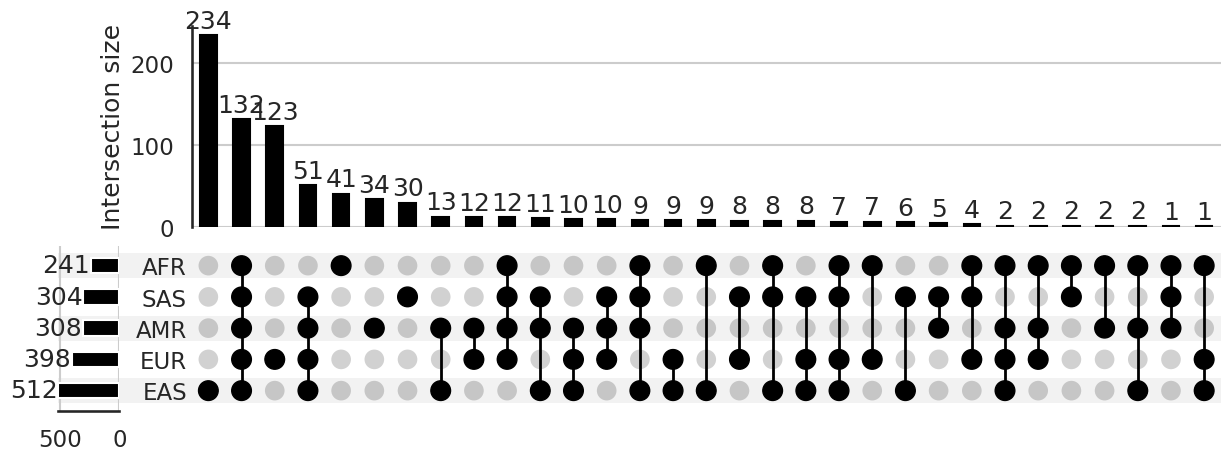

In [29]:
distStats_dict_more = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS'])
distStats_dict = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS'])
for pop in distStats_dict_more.keys():
    df  = pd.DataFrame(index = anc_div.index, columns = ['ttest_stat','ttest_pval','obs_mean','exp_mean','obs/exp','obs-exp', '-log10(p)', 'direction', 'sig'])
    alpha = 0.05/len(windows_to_keep)
    df[['ttest_stat','ttest_pval','exp_mean','obs_mean','obs/exp', 'obs-exp' , '-log10(p)', 'direction', 'sig']] = df.apply(lambda x: do_stats(x, pop), axis=1)
    df[['numWindowsAbove','numWindowsBelow']] = df.apply(count_outside, axis=1, result_type='expand')

    df_sig = df[df['ttest_pval']<=alpha]
    df_more = df_sig[df_sig['obs/exp']>1]
    df_less = df_sig[df_sig['obs/exp']<1]

    distStats_dict_more[pop] = df_more
    distStats_dict[pop] = df

more_divergent_by_pop = pd.DataFrame(index=anc_div.index)
more_divergent_by_pop = get_pop_stats()
more_divergent_by_pop = more_divergent_by_pop[(more_divergent_by_pop ==True).any(axis=1)]

upset(more_divergent_by_pop)


In [30]:
more_divergent_by_pop

AFR    AMR    EUR    EAS    SAS
chr   windowStartPos                                   
chr1  41418752         True   True   True   True   True
      57147392        False   True   True  False  False
      70778880        False  False   True  False  False
      80216064        False  False   True  False  False
      88604672        False   True   True   True   True
...                     ...    ...    ...    ...    ...
chr22 22020096         True  False   True   True  False
      22544384         True  False  False   True   True
      42991616        False  False  False  False   True
      47710208         True   True   True   True   True
      48234496         True   True   True   True   True

[805 rows x 5 columns]

/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1219477297.py:20: RuntimeWarning: divide by zero encountered in log10
  neglogp = -np.log10(p)
/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1219477297.py:20: RuntimeWarning: divide by zero encountered in log10
  neglogp = -np.log10(p)
/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1219477297.py:20: RuntimeWarning: divide by zero encountered in log10
  neglogp = -np.log10(p)
/scratch/egilbertson/ipykernel_7277/1219477297.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/121

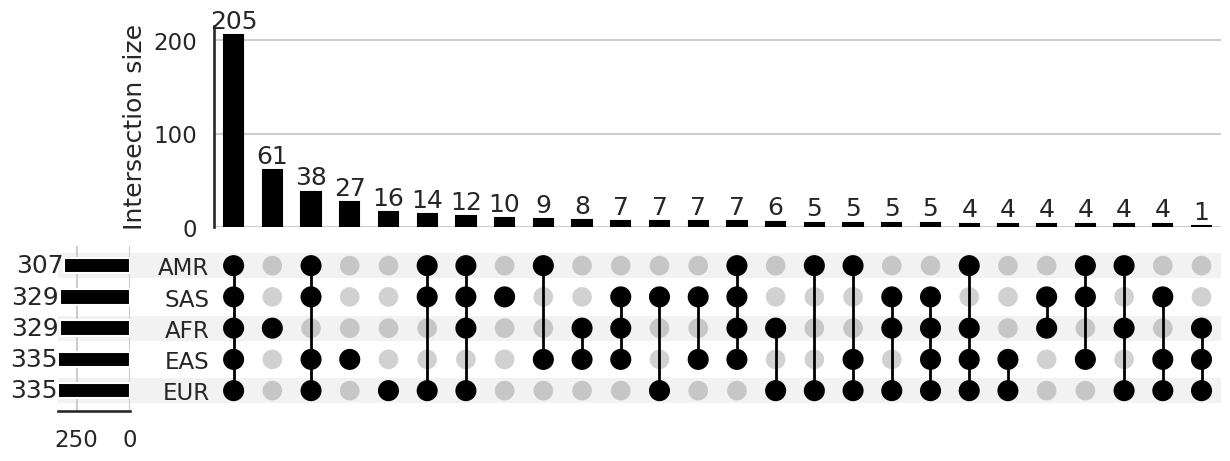

In [31]:
distStats_dict_more = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS'])
distStats_dict = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS'])
for pop in distStats_dict_more.keys():
    df  = pd.DataFrame(index = anc_div.index, columns = ['ttest_stat','ttest_pval','obs_mean','exp_mean','obs/exp','obs-exp', '-log10(p)', 'direction', 'sig'])
    alpha = 0.05/len(windows_to_keep)
    df[['ttest_stat','ttest_pval','exp_mean','obs_mean','obs/exp', 'obs-exp' , '-log10(p)', 'direction', 'sig']] = df.apply(lambda x: do_stats(x, pop, all=True), axis=1)
    df[['numWindowsAbove','numWindowsBelow']] = df.apply(count_outside, axis=1, result_type='expand')

    df_sig = df[df['ttest_pval']<=alpha]
    df_more = df_sig[df_sig['obs/exp']>1]
    df_less = df_sig[df_sig['obs/exp']<1]

    distStats_dict_more[pop] = df_more
    distStats_dict[pop] = df

more_divergent_by_pop = pd.DataFrame(index=anc_div.index)
more_divergent_by_pop = get_pop_stats()
more_divergent_by_pop = more_divergent_by_pop[(more_divergent_by_pop ==True).any(axis=1)]

upset(more_divergent_by_pop)

In [32]:
all_windows = pd.DataFrame(index=windows_to_keep).reset_index()
all_windows.columns = ['chr','start']
all_windows['end'] = all_windows['start'] + 2**20

In [33]:
more_divergent_by_pop

AFR    AMR    EUR    EAS    SAS
chr   windowStartPos                                   
chr1  41418752         True   True   True   True   True
      41943040         True  False  False  False  False
      57147392        False   True   True   True   True
      88604672         True   True   True   True   True
      92798976         True   True   True   True   True
...                     ...    ...    ...    ...    ...
chr22 22020096         True  False   True  False  False
      22544384         True  False   True  False   True
      42991616        False  False  False  False   True
      47710208         True   True   True   True   True
      48234496         True   True   True   True   True

[479 rows x 5 columns]

In [34]:
def get_div_pop(row):
    idx_list = idx_list = list(row[row==True].index)
    return [i.split('_',1)[0] for i in idx_list]

mostDivergedWindows = more_divergent_by_pop.reset_index()
mostDivergedWindows['windowStopPos'] = mostDivergedWindows['windowStartPos'] + 2**20
mostDivergedWindows['pops'] = mostDivergedWindows.apply(lambda row: get_div_pop(row), axis=1)
mostDivergedWindows = mostDivergedWindows.drop(columns=['AFR','AMR','EUR','EAS','SAS'])


In [35]:
def check_if_all_pops(row):
    if row['pops'] == ['AFR','AMR','EUR','EAS','SAS']:
        new_val = 'All'
    elif row['pops'] == ['AFR']:
        new_val = 'AFR_only'
    elif row['pops'] == ['AMR','EUR','EAS','SAS']:
        new_val = 'All_nonAFR'
    elif len(row['pops']) == 1:
        new_val = 'nonAFR_popSpecific'
    else:
        new_val = 'Other'
    return new_val

mostDivergedWindows = more_divergent_by_pop.reset_index()
mostDivergedWindows['windowStopPos'] = mostDivergedWindows['windowStartPos'] + 2**20
mostDivergedWindows['pops'] = mostDivergedWindows.apply(lambda row: get_div_pop(row), axis=1)
mostDivergedWindows = mostDivergedWindows.drop(columns=['AFR','AMR','EUR','EAS','SAS'])
mostDivergedWindows['AllvsAFR'] = mostDivergedWindows.apply(lambda row: check_if_all_pops(row), axis=1)
mostDivergedWindows_subset = mostDivergedWindows[mostDivergedWindows['AllvsAFR']!= 'Other']

adding ideograms...
All
AFR_only
All_nonAFR
nonAFR_popSpecific


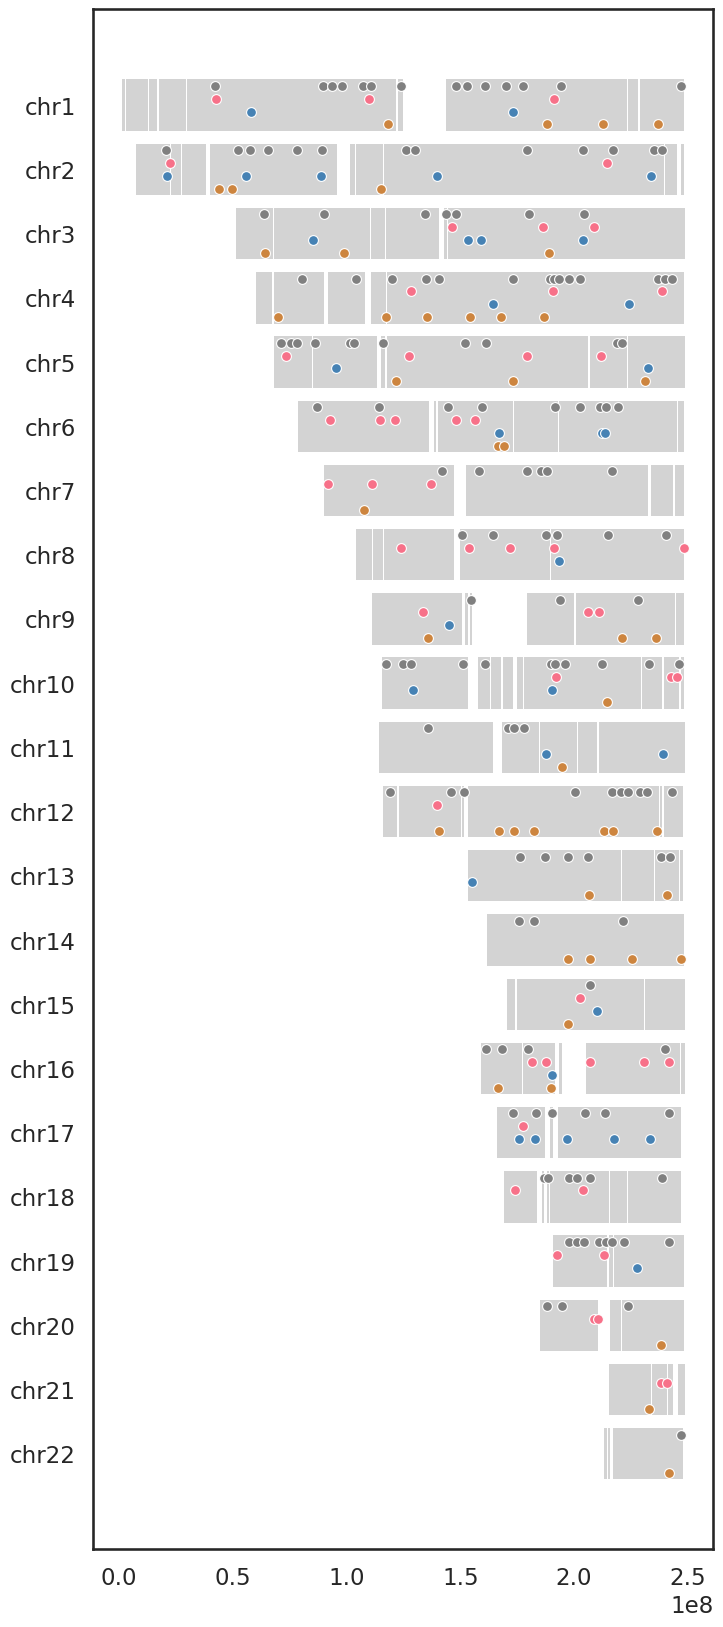

In [36]:
# From https://www.biostars.org/p/147364/#147637
from matplotlib.collections import BrokenBarHCollection

def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    df['start'] = [s + (248956422-chrlen[c]) for s,e,c in zip(df['start'],df['end'],df['chrom'])]  # remove if not right aligned
    df['end'] = [e + (248956422-chrlen[c]) for s,e,c in zip(df['start'],df['end'],df['chrom'])] # remove if not right aligned
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']
        
chrlen={'chr1':248956422,
'chr2':242193529,
'chr3':198295559,
'chr4':190214555,
'chr5':181538259,
'chr6':170805979,
'chr7':159345973,
'chr8':145138636,
'chr9':138394717,
'chr10':133797422,
'chr11':135086622,
'chr12':133275309,
'chr13':114364328,
'chr14':107043718,
'chr15':101991189,
'chr16':90338345,
'chr17':83257441,
'chr18':80373285,
'chr19':58617616,
'chr20':64444167,
'chr21':46709983,
'chr22':50818468,
'chrX':156040895,
'chrY':57227415,
'chrM':16569}

# Height of each ideogram
chrom_height = 4

# Spacing between consecutive ideograms
chrom_spacing = 1

# Width, height (in inches)
figsize = (8, 20)

# Decide which chromosomes to use
chromosome_list = ['chr%s' % i for i in list(range(1, 23))] #can add 'X', 'Y','M' + ['X']

# Keep track of the y positions for ideograms and genes for each chromosome,
# and the center of each ideogram (which is where we'll put the ytick labels)
ybase = 0
chrom_ybase = {}
gene_ybase = {}
gene_ybase2 = {}
gene_ybase3 = {}
gene_ybase4 = {}

chrom_centers = {}
# Iterate in reverse so that items in the beginning of `chromosome_list` will
# appear at the top of the plot
for chrom in chromosome_list[::-1]:
    chrom_ybase[chrom] = ybase
    chrom_centers[chrom] = ybase + chrom_height / 2.
    ybase += chrom_height + chrom_spacing

# Read in ideogram.txt, downloaded from UCSC Table Browser
ideo = all_windows

# Filter out chromosomes not in our list
ideo = ideo[ideo.chr.apply(lambda x: x in chromosome_list)]
ideo = ideo.rename(columns = {"chr":"chrom"})
# Add a new column for width
ideo['width'] = ideo.end - ideo.start
ideo['colors'] = 'lightgray'

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# Now all we have to do is call our function for the ideogram data...
print("adding ideograms...")
for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, linewidths=0):
    _ = ax.add_collection(collection)

## Insert our custom data
sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832'}
for i,modifier, color in zip(['All','AFR_only','All_nonAFR', 'nonAFR_popSpecific'],[3.5, 2.5,1.5,0.5],['grey',sup_pal['AFR'],'steelblue', 'peru']):
    print(i)
    subset = mostDivergedWindows_subset[mostDivergedWindows_subset['AllvsAFR'] == i]
    subset = BedTool.from_dataframe(subset).merge().to_dataframe()
    ycoords = np.array([chrom_ybase[x] for x in subset['chrom'].values]) + modifier
    #xcoords = np.array([(s + e)/2 for s,e in zip(subset['start'],subset['end'])]) # if left aligned
    xcoords = np.array([(s + e)/2 + (249250621-chrlen[c]) for s,e,c in zip(subset['start'],subset['end'],subset['chrom'])])
    _ = ax.scatter(xcoords,ycoords,color=color,s=50,edgecolors= "white",linewidth=0.8)


# Axes tweaking
_ = ax.set_yticks([chrom_centers[i] for i in chromosome_list])
_ = ax.set_yticklabels(chromosome_list)

ax.axis('tight')
#plt.savefig("/home/mcarthe/ideogram.pdf")
plt.show()

### set up

In [37]:
def do_stats(row):
    i = row.name
    obs = anc_div.loc[i]
    exp = eDists_all.loc[i]
    t,p = stats.ttest_ind(exp,obs)
    
    obs_mean = obs.mean()
    exp_mean = exp.mean()
    ratio = obs_mean/exp_mean
    delta = obs_mean - exp_mean
    neglogp = -np.log10(p)
    if delta > 0:
        direction = 'higher'
    if delta < 0:
        direction = 'lower'

    sig = p<0.05/len(windows_to_keep)
    return pd.Series([t, p, exp_mean, obs_mean, ratio, delta, neglogp, direction, sig])


# find number of individuals that have lower observed divergence than expected for each window
def count_outside(row):
    i = row.name
    above = len(anc_div.loc[i][anc_div.loc[i] > anc_div_summary['emp_max'].loc[i]])
    below = len(anc_div.loc[i][anc_div.loc[i] < anc_div_summary['emp_min'].loc[i]])
    return above, below

In [38]:
distStats = pd.DataFrame(index = anc_div.index, columns = ['ttest_stat','ttest_pval','obs_mean','exp_mean','obs/exp','obs-exp', '-log10(p)', 'direction', 'sig'])
alpha = 0.05/len(windows_to_keep)
distStats[['ttest_stat','ttest_pval','exp_mean','obs_mean','obs/exp', 'obs-exp' , '-log10(p)', 'direction', 'sig']] = distStats.apply(do_stats, axis=1)
distStats[['numWindowsAbove','numWindowsBelow']] = distStats.apply(count_outside, axis=1, result_type='expand')


distStats_sig = distStats[distStats['ttest_pval']<=alpha]
distStats_more = distStats_sig[distStats_sig['obs/exp']>1]
distStats_less = distStats_sig[distStats_sig['obs/exp']<1]


/scratch/egilbertson/ipykernel_7277/1212352188.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = obs_mean/exp_mean
/scratch/egilbertson/ipykernel_7277/1212352188.py:11: RuntimeWarning: divide by zero encountered in log10
  neglogp = -np.log10(p)


Number of windows significantly different from expected

In [39]:
print(distStats_less.shape[0] + distStats_more.shape[0])
print(distStats_sig.shape[0])

4434
4434


Number of windows not significantly different than expected

In [40]:
len(windows_to_keep) - (distStats_sig.shape[0])

439

In [41]:
# drop windows where observed == 0, n=8
distStats = distStats[distStats['obs_mean']!=0]
distStats_sig = distStats[distStats['ttest_pval']<=alpha]
distStats_more = distStats_sig[distStats_sig['obs/exp']>1]
distStats_less = distStats_sig[distStats_sig['obs/exp']<1]

### counting number of +/- diverged than expected individuals per window

In [42]:
distStats

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  1048576          20.535906   1.045954e-87  0.001068  0.003634  0.293991   
      1572864          28.000778  3.288944e-153  0.001490  0.006541  0.227866   
      3145728           7.259478   4.945922e-13  0.003121  0.004522  0.690173   
      3670016           9.733537   4.638277e-22  0.004617  0.007087  0.651480   
      4194304          10.998926   1.318518e-27  0.008626  0.015544  0.554951   
...                          ...            ...       ...       ...       ...   
chr22 46661632         22.979621  1.215207e-107  0.003650  0.013944  0.261784   
      47185920         21.726243   3.240259e-97  0.007319  0.031791  0.230209   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   
      48758784         25.344617  2.168919e-128  0.005756  0.028964  0.198738   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  1048576        -0.002565   86.980488     lower  True                0   
      1572864        -0.005050  152.482944     lower  True                0   
      3145728        -0.001401   12.305753     lower  True                0   
      3670016        -0.002470   21.333643     lower  True                1   
      4194304        -0.006918   26.879914     lower  True                1   
...                        ...         ...       ...   ...              ...   
chr22 46661632       -0.010294  106.915350     lower  True                0   
      47185920       -0.024472   96.489420     lower  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   
      48758784       -0.023208  127.663757     lower  True                0   

                      numWindowsBelow  
chr   windowStartPos                   
chr1  1048576                      59  
      1572864                      40  
      3145728                      12  
      3670016                       0  
      4194304                       0  
...                               ...  
chr22 46661632                     70  
      47185920                      3  
      47710208                      0  
      48234496                      0  
      48758784                      9  

[4873 rows x 11 columns]

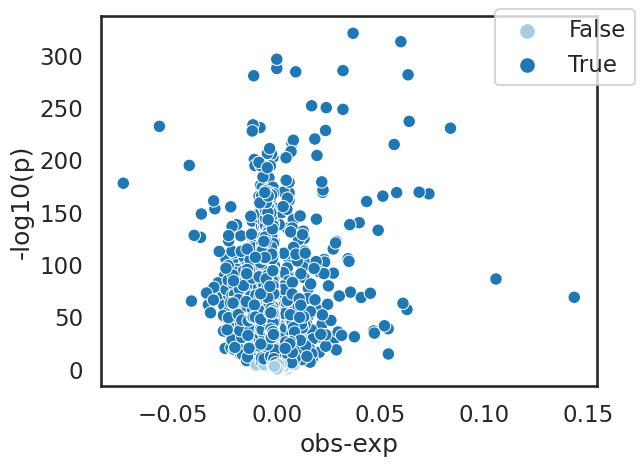

In [43]:
sns.scatterplot(x = 'obs-exp', y = '-log10(p)', data = distStats, hue='sig', palette='Paired')
plt.legend(bbox_to_anchor=(1.1, 1.05))

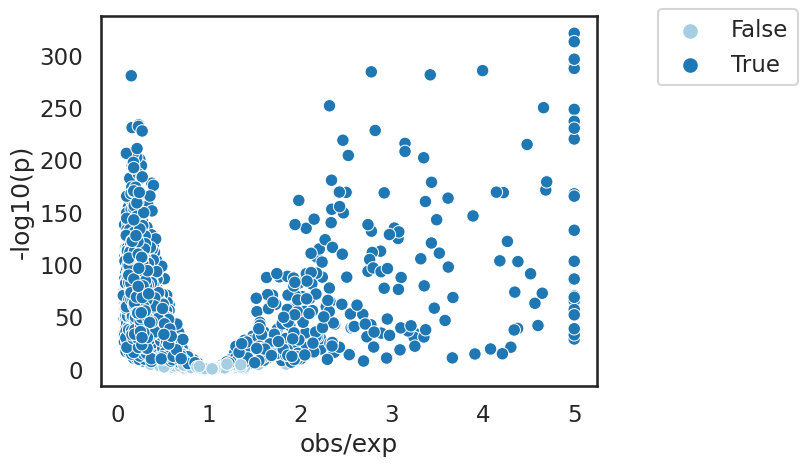

In [44]:
distStats_clipped_ratio = distStats.copy(deep=True)
distStats_clipped_ratio['obs/exp'] = distStats_clipped_ratio['obs/exp'].clip(0,5)
sns.scatterplot(x = 'obs/exp', y = '-log10(p)', data = distStats_clipped_ratio, hue='sig', palette='Paired')
plt.legend(bbox_to_anchor=(1.1, 1.05))

Text(0.5, 1.0, 'Distribution of number of individuals outside \n of expected distribution in windows that are \nsignificantly more diverged than expected')

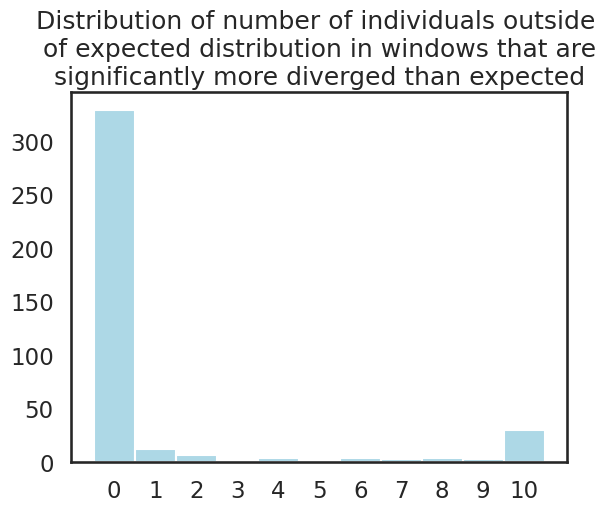

In [45]:
distStats_clipped_numWindowsAbove = distStats_more.copy(deep=True)
distStats_clipped_numWindowsAbove['numWindowsAbove'] = distStats_clipped_numWindowsAbove['numWindowsAbove'].clip(0,10)
plt.hist(distStats_clipped_numWindowsAbove['numWindowsAbove'], align='left', rwidth=1, bins=[0,1,2,3,4,5,6,7,8,9,10,11], color = 'lightblue')
plt.xticks(range(11))
plt.title("Distribution of number of individuals outside \n of expected distribution in windows that are \nsignificantly more diverged than expected")


Text(0.5, 1.0, 'Distribution of number of individuals outside \n of expected distribution in windows that are \nsignificantly less diverged than expected')

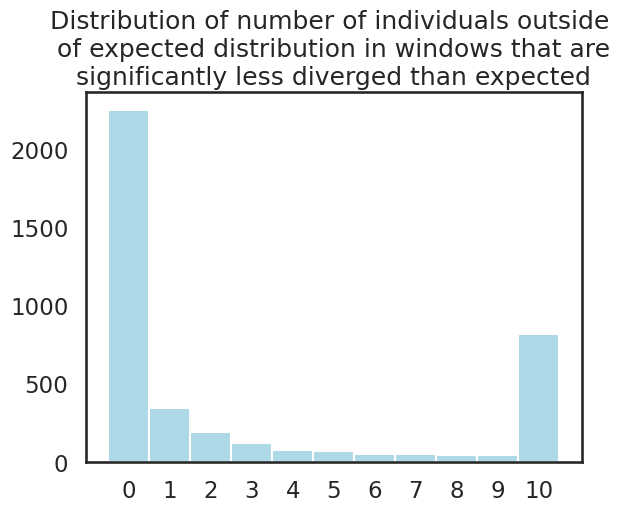

In [46]:
distStats_clipped_numWindowsBelow = distStats_less.copy(deep=True)
distStats_clipped_numWindowsBelow['numWindowsBelow'] = distStats_clipped_numWindowsBelow['numWindowsBelow'].clip(0,10)
plt.hist(distStats_clipped_numWindowsBelow['numWindowsBelow'], align='left', rwidth=1, bins=[0,1,2,3,4,5,6,7,8,9,10,11], color = 'lightblue')
plt.xticks(range(11))
plt.title("Distribution of number of individuals outside \n of expected distribution in windows that are \nsignificantly less diverged than expected")

In [47]:
distStats_clipped_numWindowsAbove['numWindowsAbove']

chr    windowStartPos
chr1   41418752           2
       57147392           1
       70778880           0
       88604672           7
       92798976           0
                         ..
chr21  35127296           0
chr22  22020096           0
       22544384           0
       47710208           0
       48234496          10
Name: numWindowsAbove, Length: 392, dtype: int64

In [48]:
def plot_dists(idxs):
    for i in idxs:
        print(i)
        plt.figure(figsize=(12,6))
        mini = anc_div_summary.loc[i].min()
        maxi = anc_div_summary.loc[i].max()
        width = (maxi-mini)/100
        ax = sns.histplot(eDists_all.loc[i], alpha=.2, color='k', binwidth=width, element='step')

        emp_max = anc_div_summary.loc[i]['emp_max']
        emp_min = anc_div_summary.loc[i]['emp_min']
        emp_mean = eDists.loc[i]['mean']
        obs_mean = anc_div.loc[i].mean()
        plt.axvline(x = emp_max,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           lw = 2, color = 'k') 
        plt.axvline(x = emp_min,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           lw = 2, color = 'k') 
        plt.axvline(x = emp_mean,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'grey') 
        plt.axvline(x = obs_mean,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'steelblue') 

        sns.histplot(anc_div['AFR'].loc[i], alpha=.5, linewidth=0, binwidth=width)
        sns.histplot(anc_div['EUR'].loc[i], alpha=.5, linewidth=0, binwidth=width)
        sns.histplot(anc_div['EAS'].loc[i], alpha=.5, linewidth=0, binwidth=width)
        sns.histplot(anc_div['SAS'].loc[i], alpha=.5, linewidth=0, binwidth=width)
        sns.histplot(anc_div['AMR'].loc[i], alpha=.5, linewidth=0, binwidth=width)
        plt.xlabel('3D Divergence')
        plt.suptitle('Population observed divergence (colors) with expected divergence (grey)')
        plt.title(i)
        plt.show()
    return

('chr5', 18350080)


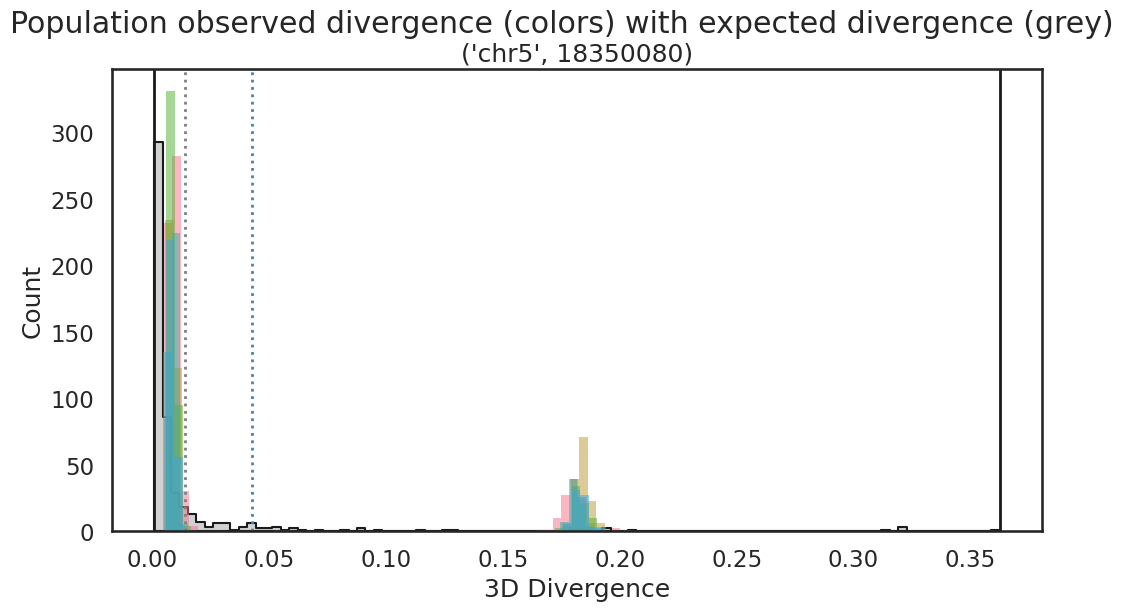

('chr7', 125829120)


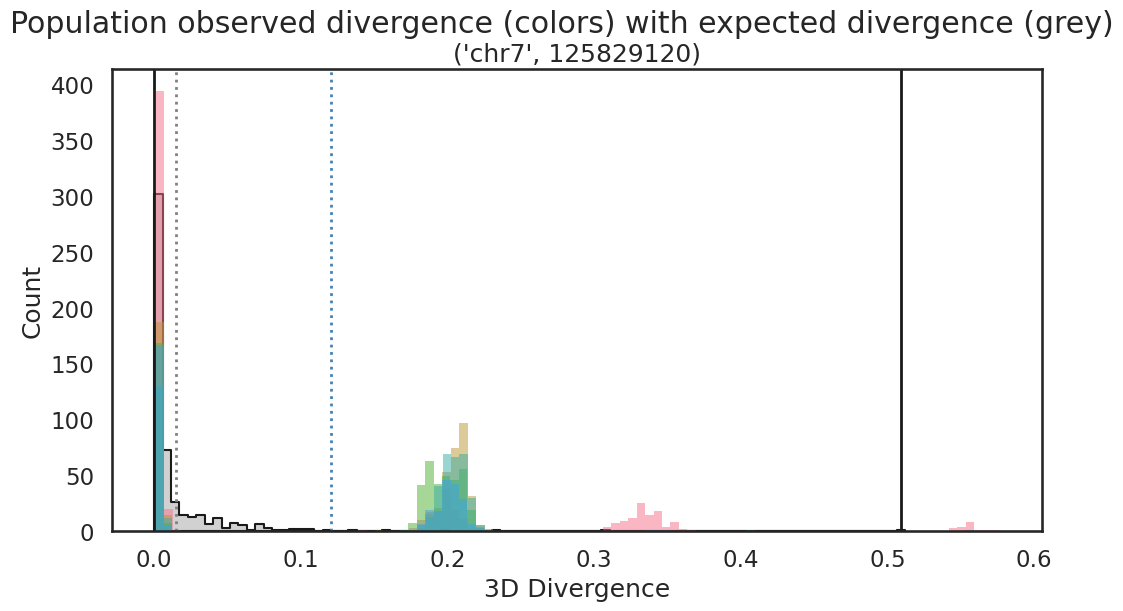

In [49]:
plot_dists([('chr5', 18350080), ('chr7', 125829120)])

('chr10', 95944704)


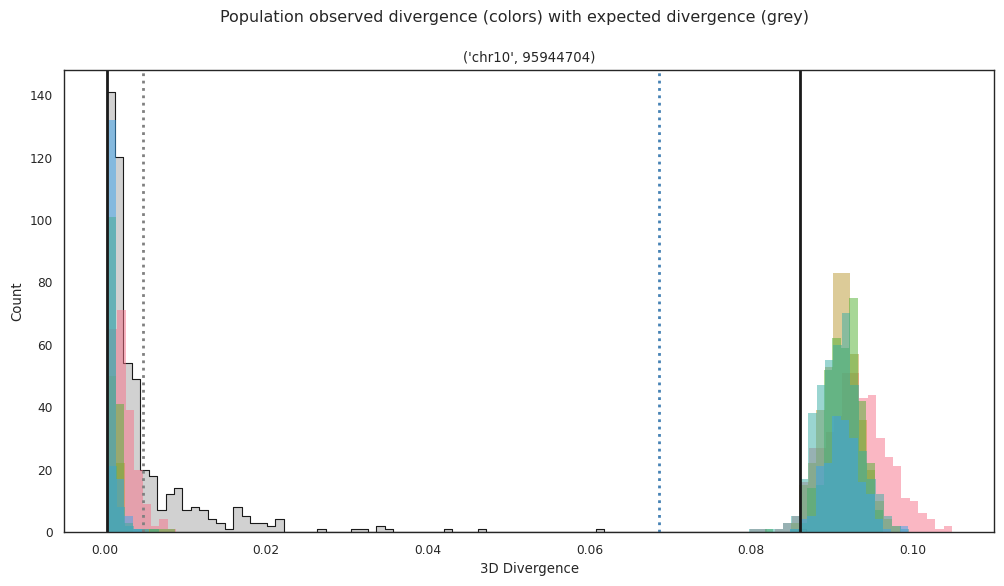

('chr8', 88080384)


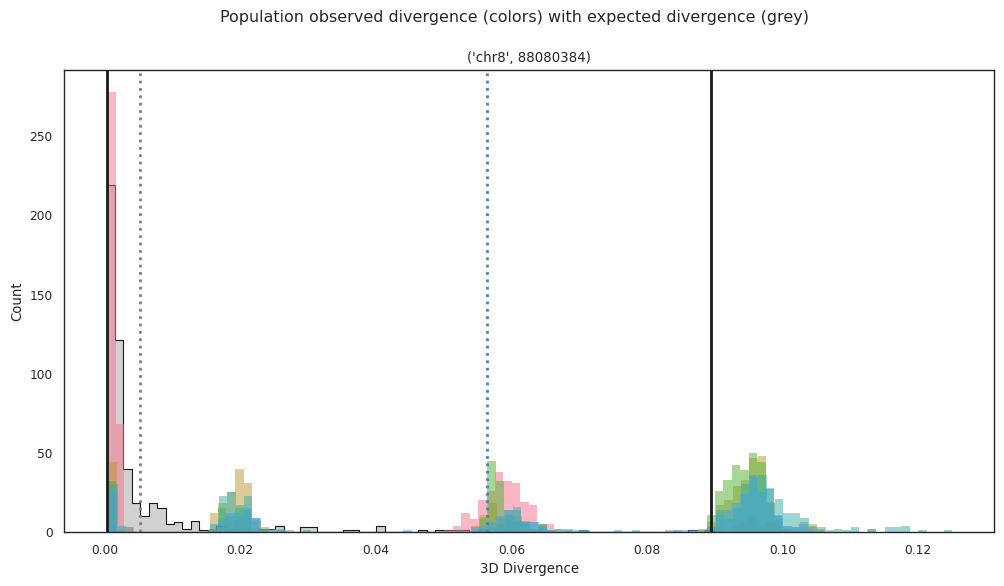

('chr1', 152567808)


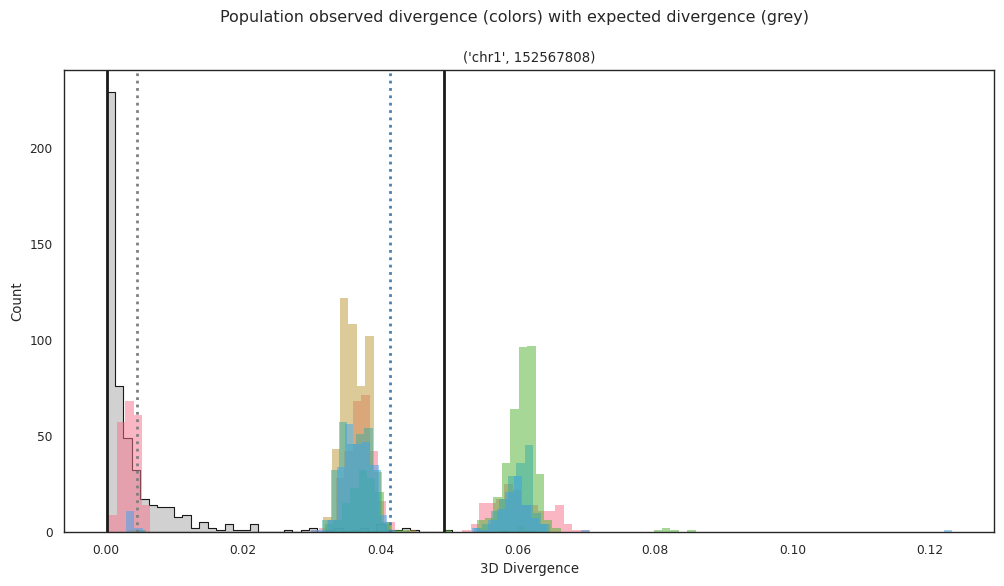

In [95]:
idxs = [('chr10', 95944704), ('chr8', 88080384),  ('chr1', 152567808)]
plot_dists(idxs)

('chr15', 31981568)


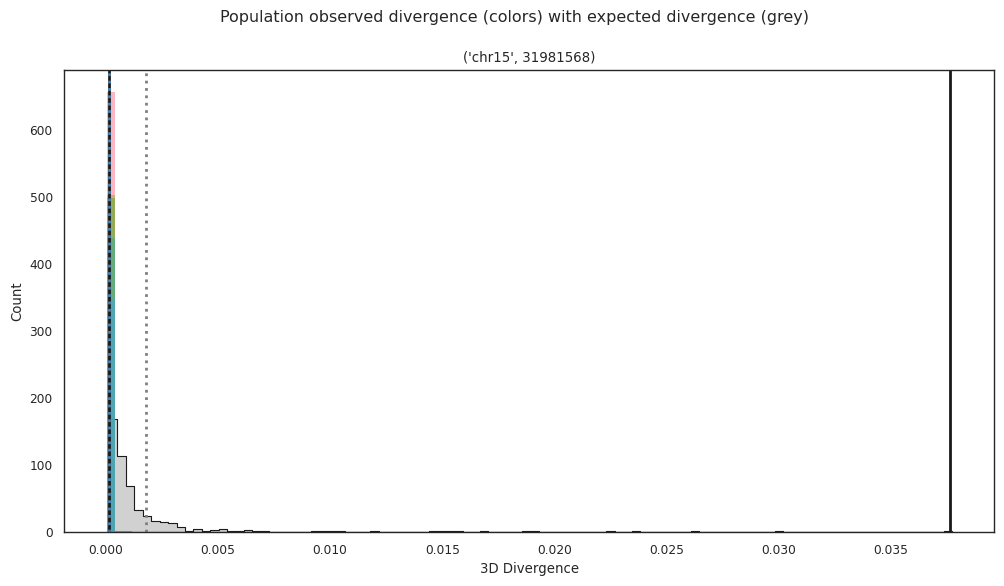

('chr2', 94896128)


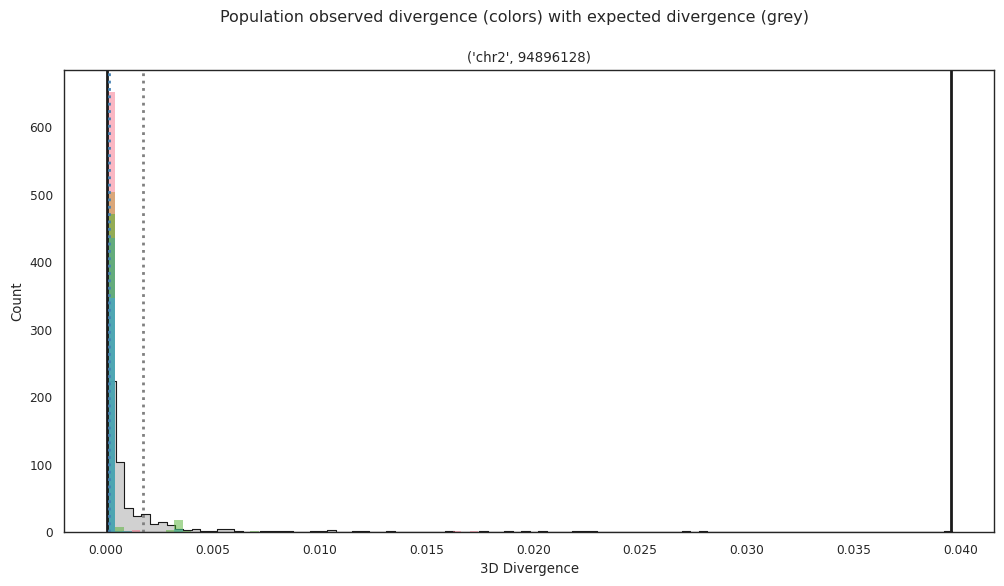

('chr8', 37224448)


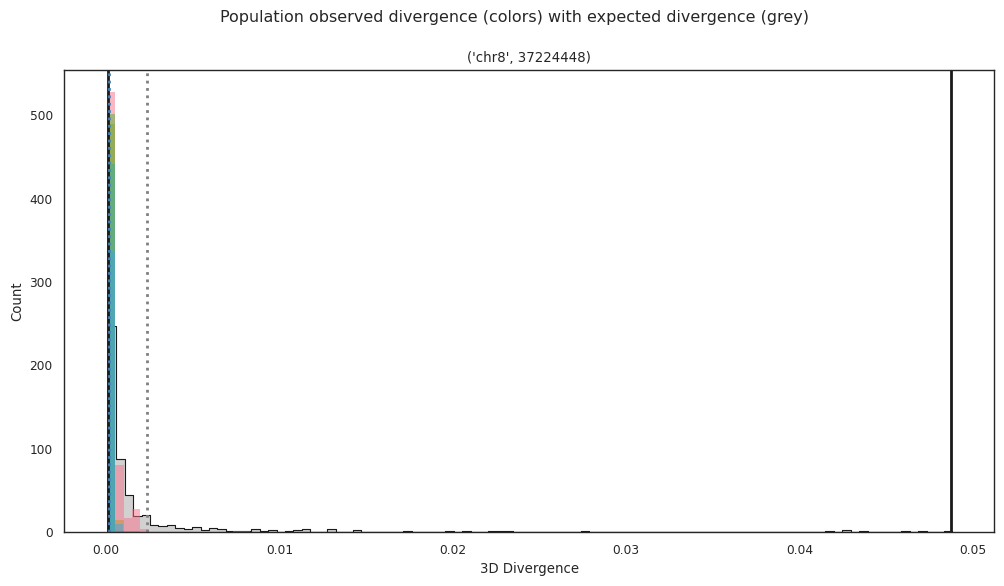

('chr3', 31457280)


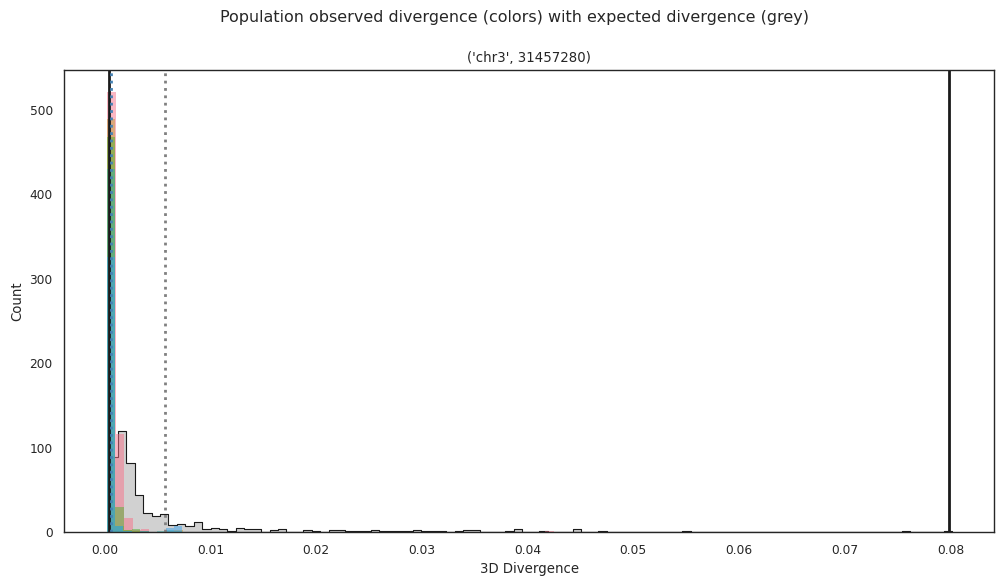

('chr15', 74973184)


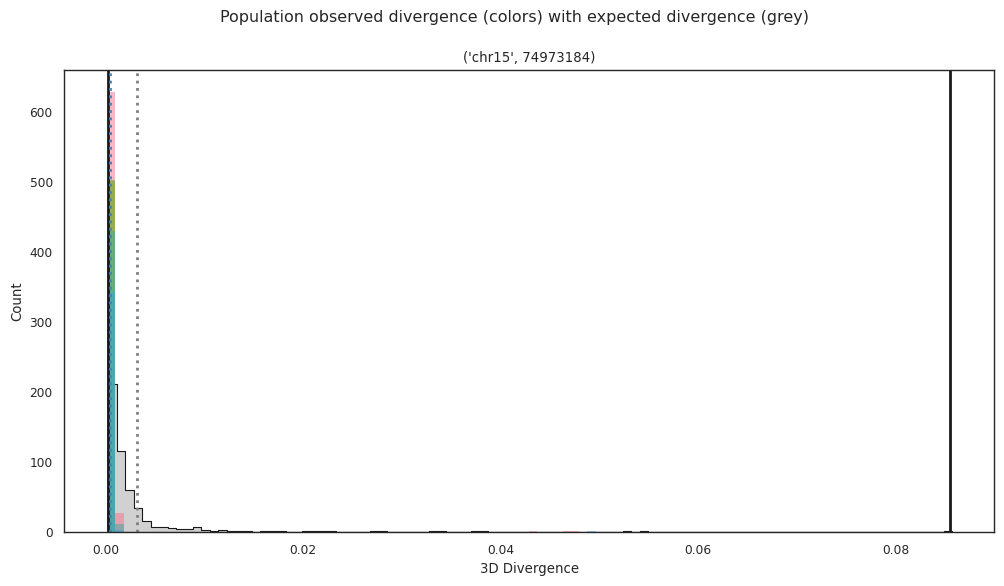

('chr19', 14680064)


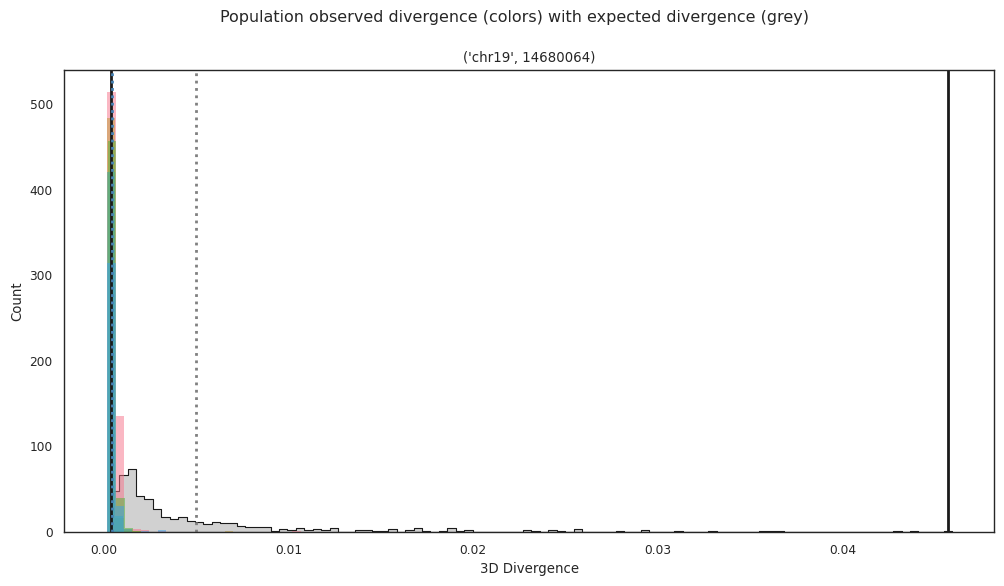

('chr7', 41943040)


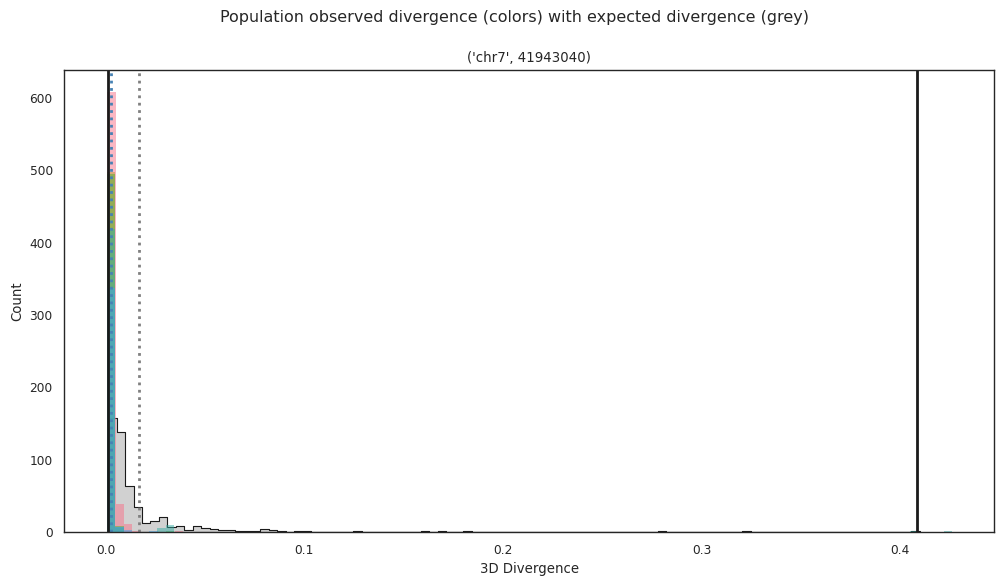

('chr13', 47710208)


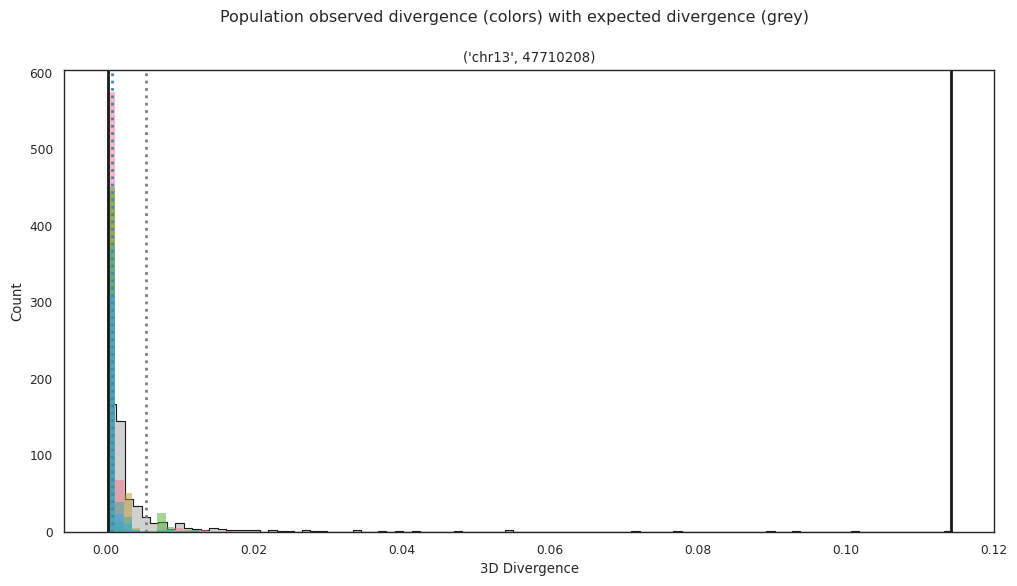

('chr16', 72351744)


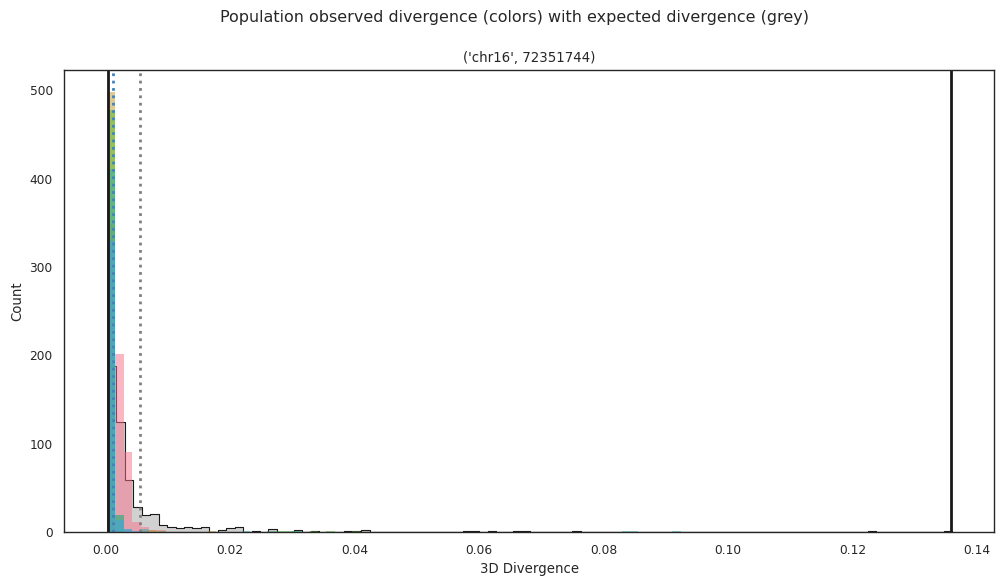

('chr20', 34078720)


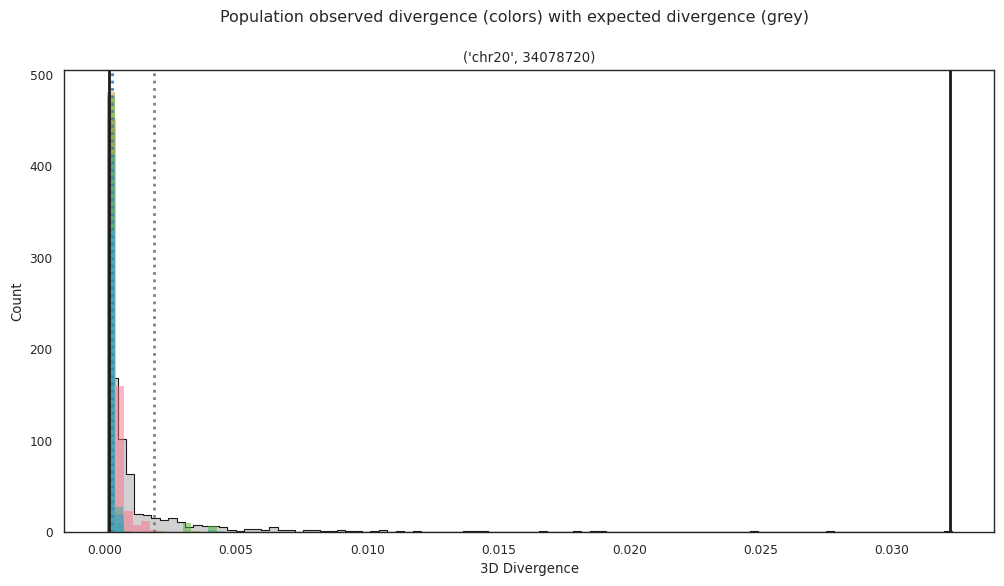

In [96]:
idxs = distStats_less[distStats_less['obs_mean']!=0][distStats_less['ttest_pval']<=alpha].sort_values(by='numWindowsBelow', ascending=False).head(n=10).index
plot_dists(idxs)

In [97]:
anc_div.loc[('chr10', 95944704)].idxmax()

('AFR', 'MSL', 'female', 'HG03575')

In [98]:
anc_div.loc[('chr10', 95944704)].idxmin()

('EAS', 'CHS', 'female', 'HG00407')

In [99]:
a = pd.DataFrame(anc_div.loc[('chr8', 88080384)])

In [100]:
a.columns = ['chrm']

In [101]:
a[a.chrm >.08].index

MultiIndex([('AFR', 'ACB', 'female', 'HG01880'),
            ('AFR', 'ACB', 'female', 'HG01886'),
            ('AFR', 'ACB', 'female', 'HG01915'),
            ('AFR', 'ACB', 'female', 'HG02427'),
            ('AFR', 'ACB', 'female', 'HG02497'),
            ('AFR', 'ACB', 'female', 'HG02502'),
            ('AFR', 'ACB', 'female', 'HG02546'),
            ('AFR', 'ACB',   'male', 'HG01879'),
            ('AFR', 'ACB',   'male', 'HG01986'),
            ('AFR', 'ACB',   'male', 'HG02307'),
            ...
            ('SAS', 'STU',   'male', 'HG03856'),
            ('SAS', 'STU',   'male', 'HG03885'),
            ('SAS', 'STU',   'male', 'HG03887'),
            ('SAS', 'STU',   'male', 'HG03953'),
            ('SAS', 'STU',   'male', 'HG03985'),
            ('SAS', 'STU',   'male', 'HG03991'),
            ('SAS', 'STU',   'male', 'HG04006'),
            ('SAS', 'STU',   'male', 'HG04033'),
            ('SAS', 'STU',   'male', 'HG04039'),
            ('SAS', 'STU',   'male', 'HG04210')],
   

<AxesSubplot: xlabel='obs_mean', ylabel='obs/exp'>

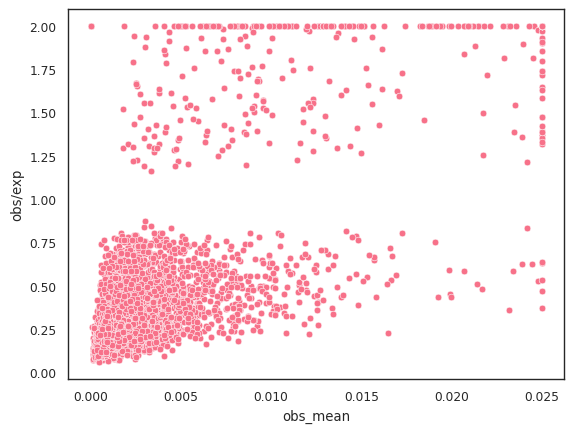

In [102]:
clipped = distStats[distStats['ttest_pval']<=alpha].copy(deep=True)
clipped['obs_mean'] = clipped['obs_mean'].clip(0,.025)
clipped['obs/exp'] = clipped['obs/exp'].clip(0,2)
sns.scatterplot(data = clipped, x = 'obs_mean', y = 'obs/exp')

## Choosing windows for enrichment

In [103]:
eDists

AFR     EUR     EAS     SAS   AMR         0         1  \
chr   start_pos                                                           
chr1  1048576    2265  1819.0  1918.0  2086.0  1949  0.002750  0.018778   
      1572864    1954  1771.0  1899.0  1696.0  1906  0.003038  0.045816   
      3145728    2488  2296.0  2220.0  2263.0  2182  0.002392  0.001234   
      3670016    2579  2513.0  2481.0  2382.0  2289  0.018037  0.005422   
      4194304    2283  2156.0  2194.0  2108.0  2159  0.013594  0.002850   
...               ...     ...     ...     ...   ...       ...       ...   
chr22 46661632   2327  2153.0  2174.0  2093.0  2164  0.013603  0.015859   
      47185920   2262  2077.0  2098.0  2096.0  2016  0.007078  0.008193   
      47710208   2731  2570.0  2467.0  2687.0  2421  0.002735  0.014434   
      48234496   3408  3198.0  3134.0  3231.0  3223  0.024981  0.015043   
      48758784   3151  2810.0  2949.0  2794.0  3042  0.014510  0.170791   

                        2         3         4  ...       491       492  \
chr   start_pos                                ...                       
chr1  1048576    0.002220  0.002877  0.004057  ...  0.004541  0.005529   
      1572864    0.010242  0.001534  0.050068  ...  0.003903  0.001946   
      3145728    0.002069  0.005067  0.046430  ...  0.004059  0.002544   
      3670016    0.021796  0.011557  0.004166  ...  0.037425  0.001942   
      4194304    0.134349  0.007526  0.005112  ...  0.008926  0.004450   
...                   ...       ...       ...  ...       ...       ...   
chr22 46661632   0.013423  0.002194  0.004338  ...  0.010736  0.003168   
      47185920   0.015783  0.022257  0.014342  ...  0.005423  0.032439   
      47710208   0.011769  0.006697  0.014336  ...  0.002968  0.002173   
      48234496   0.076889  0.016475  0.013504  ...  0.014638  0.007498   
      48758784   0.013307  0.004097  0.003268  ...  0.011146  0.010424   

                      493       494       495       496       497       498  \
chr   start_pos                                                               
chr1  1048576    0.000563  0.003102  0.001023  0.007286  0.002419  0.056039   
      1572864    0.002811  0.002791  0.002086  0.004250  0.001329  0.003286   
      3145728    0.000711  0.001414  0.000727  0.000626  0.009045  0.000850   
      3670016    0.012370  0.003331  0.011110  0.003452  0.006914  0.003470   
      4194304    0.003433  0.009688  0.004421  0.007084  0.007027  0.005514   
...                   ...       ...       ...       ...       ...       ...   
chr22 46661632   0.013606  0.004810  0.030732  0.006700  0.004860  0.004822   
      47185920   0.043288  0.012194  0.029256  0.003676  0.013722  0.012104   
      47710208   0.024705  0.005211  0.010855  0.003457  0.034940  0.002849   
      48234496   0.006979  0.032564  0.010105  0.025300  0.014685  0.009948   
      48758784   0.010381  0.007563  0.003326  0.005941  0.007538  0.003040   

                      499      mean  
chr   start_pos                      
chr1  1048576    0.001587  0.003634  
      1572864    0.003154  0.006541  
      3145728    0.000956  0.004522  
      3670016    0.003453  0.007087  
      4194304    0.094583  0.015544  
...                   ...       ...  
chr22 46661632   0.045966  0.013944  
      47185920   0.003688  0.031791  
      47710208   0.003856  0.020211  
      48234496   0.015261  0.035823  
      48758784   0.005213  0.028964  

[4873 rows x 506 columns]

In [104]:
distStats_more = distStats_more.merge(anc_div_summary, left_index=True, right_index=True)

In [105]:
distStats_more

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       ALL       AFR       EUR       EAS       SAS  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.011143  0.010108  0.011830  0.013180  0.011994   
      57147392        ...  0.021517  0.009149  0.031168  0.016713  0.022907   
      70778880        ...  0.003761  0.003670  0.003780  0.003793  0.003737   
      88604672        ...  0.014955  0.007492  0.022346  0.014407  0.018429   
      92798976        ...  0.071182  0.062220  0.047517  0.096720  0.079656   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030532  0.034489  0.028786  0.028111  0.029609   
chr22 22020096        ...  0.023887  0.027355  0.024776  0.021138  0.021943   
      22544384        ...  0.011776  0.015540  0.012083  0.008256  0.011551   
      47710208        ...  0.055388  0.055222  0.060998  0.053654  0.047932   
      48234496        ...  0.204145  0.204803  0.214279  0.197077  0.187644   

                           AMR       min       max   emp_min   emp_max  
chr   windowStartPos                                                    
chr1  41418752        0.008076  0.000214  0.061708  0.000240  0.047160  
      57147392        0.036207  0.000460  0.241914  0.000711  0.198873  
      70778880        0.003891  0.000125  0.015220  0.000125  0.071377  
      88604672        0.014783  0.000098  0.068938  0.000080  0.055810  
      92798976        0.074693  0.000381  0.260017  0.000371  0.454930  
...                        ...       ...       ...       ...       ...  
chr21 35127296        0.030236  0.008522  0.120146  0.001044  0.323117  
chr22 22020096        0.022474  0.001957  0.055087  0.001038  0.190579  
      22544384        0.009572  0.000380  0.032310  0.000370  0.141347  
      47710208        0.059584  0.001600  0.142327  0.001173  0.203276  
      48234496        0.219469  0.00

In [106]:
distStats_more.to_csv('%s/divergent_windows_exp_distributions.txt' % DATA_PATH)

In [230]:
distStats_more[distStats_more.numWindowsAbove>0]

ttest_stat     ttest_pval      obs_mean  exp_mean  \
chr   windowStartPos                                                      
chr1  41418752        -26.987165  1.461871e-143  1.114315e-02  0.003190   
      57147392        -11.867927   9.060743e-32  2.151668e-02  0.007885   
      88604672        -17.578602   7.272380e-66  1.495526e-02  0.002522   
      122683392       -41.408174  6.696152e-296  7.602236e-11  0.000000   
      123207680       -41.470386  1.310895e-296  6.530488e-11  0.000000   
...                          ...            ...           ...       ...   
chr19 50855936        -24.556927  2.489778e-121  4.000298e-02  0.011646   
chr20 38273024        -15.592796   9.772427e-53  2.650102e-02  0.004515   
chr21 20971520         -5.014099   5.643068e-07  2.172378e-02  0.014485   
      21495808         -7.269744   4.590344e-13  3.057422e-02  0.016029   
chr22 48234496        -55.442420   0.000000e+00  2.041451e-01  0.035823   

                       obs/exp       obs-exp   -log10(p) direction   sig  \
chr   windowStartPos                                                       
chr1  41418752        3.492743  7.952778e-03  142.835091    higher  True   
      57147392        2.728665  1.363126e-02   31.042836    higher  True   
      88604672        5.929643  1.243314e-02   65.138323    higher  True   
      122683392            inf  7.602236e-11  295.174175    higher  True   
      123207680            inf  6.530488e-11  295.882432    higher  True   
...                        ...           ...         ...       ...   ...   
chr19 50855936        3.434899  2.835694e-02  120.603839    higher  True   
chr20 38273024        5.869739  2.198616e-02   52.009998    higher  True   
chr21 20971520        1.499730  7.238654e-03    6.248485    higher  True   
      21495808        1.907383  1.454482e-02   12.338155    higher  True   
chr22 48234496        5.698711  1.683221e-01         inf    higher  True   

                      numWindowsAbove  numWindowsBelow  
chr   windowStartPos                                    
chr1  41418752                      2                3  
      57147392                      1               32  
      88604672                      7                0  
      122683392                  1903                0  
      123207680                  1903                0  
...                               ...              ...  
chr19 50855936                     12                7  
chr20 38273024                    270                1  
chr21 20971520                      1                1  
      21495808                      1               10  
chr22 48234496                    367                0  

[63 rows x 11 columns]

(array([118.,  88.,  46.,  33.,  18.,  12.,  15.,   8.,   8.,   3.,   7.,
          3.,   3.,   4.,   3.,   5.,   2.,   2.,   4.,   0.,   1.,   3.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([2.93462474e-11, 3.36644183e-03, 6.73288363e-03, 1.00993254e-02,
        1.34657672e-02, 1.68322090e-02, 2.01986508e-02, 2.35650926e-02,
        2.69315344e-02, 3.02979762e-02, 3.36644180e-02, 3.70308598e-02,
        4.03973016e-02, 4.37637434e-02, 4.71301852e-02, 5.04966270e-02,
        5.38630688e-02, 5.72295106e-02, 6.05959524e-02, 6.39623942e-02,
        6.73288361e-02, 7.06952779e-02, 7.40617197e-02, 7.74281615e-02,
        8.07946033e-02, 8.41610451e-02, 8.75274869e-02, 9.08939287e-02,
        9.42603705e-02, 9.76268123e-02, 1.00993254e-01, 1.04359696e-01,
        1.07726138e-01, 1.11092579e-01, 1.14459021e-01, 1.17825463e-01,
        1.

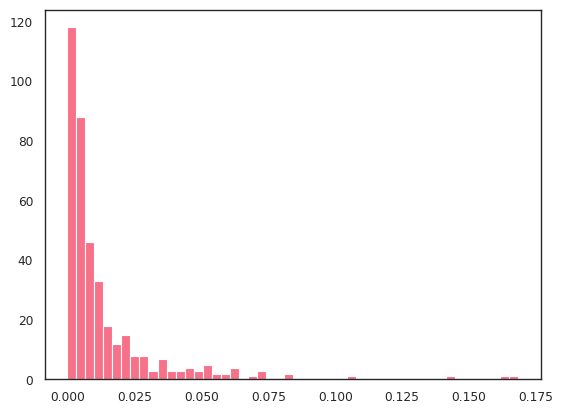

In [232]:
plt.hist(distStats_more['obs-exp'], bins=50)

In [270]:
distStats_more['obs-exp'].describe()[5]

0.006287719218215826

In [269]:
distStats_more[distStats_more['obs-exp']>=distStats_more['obs-exp'].describe()[6]]

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
      152043520       -45.319568   0.000000e+00  0.051961  0.007777  6.681739   
      152567808       -48.802296   0.000000e+00  0.041356  0.004639  8.914519   
      193462272       -40.175529  6.292926e-282  0.089410  0.026122  3.422720   
      193986560      -103.980010   0.000000e+00  0.189812  0.025896  7.329808   
...                          ...            ...       ...       ...       ...   
chr20 2621440         -21.695692   5.747803e-97  0.027233  0.009219  2.954044   
      9437184         -25.903261  1.749786e-133  0.058013  0.009150  6.340281   
      38273024        -15.592796   9.772427e-53  0.026501  0.004515  5.869739   
chr22 47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  92798976        0.062755   57.088959    higher  True                0   
      152043520       0.044184         inf    higher  True               22   
      152567808       0.036717         inf    higher  True              798   
      193462272       0.063287  281.201147    higher  True                1   
      193986560       0.163916         inf    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr20 2621440         0.018014   96.240498    higher  True                0   
      9437184         0.048863  132.757015    higher  True                0   
      38273024        0.021986   52.009998    higher  True              270   
chr22 47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      numWindowsBelow  
chr   windowStartPos                   
chr1  92798976                      0  
      152043520                     0  
      152567808                     0  
      193462272                     0  
      193986560                     0  
...                               ...  
chr20 2621440                       0  
      9437184                       6  
      38273024                      1  
chr22 47710208                      0  
      48234496                      0  

[98 rows x 11 columns]

In [247]:
distStats_more[distStats_more['obs-exp']>=distStats_more['obs-exp'].describe()[5]].index

,chr,windowStartPos
0,chr1,41418752
1,chr1,57147392
2,chr1,88604672
3,chr1,92798976
4,chr1,96993280
...,...,...
191,chr21,20971520
192,chr21,21495808
193,chr21,35127296
194,chr22,47710208


In [369]:
distStats_more

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752         -9.559214   1.614723e-20  0.010108  0.004141  2.441330   
      92798976         -6.475368   1.700655e-10  0.062220  0.010531  5.908069   
      96993280        -16.595624   5.515718e-53  0.019414  0.003997  4.856546   
      97517568        -11.461071   3.729488e-28  0.011072  0.003409  3.247361   
      106430464        -7.312758   6.673255e-13  0.012807  0.006891  1.858614   
...                          ...            ...       ...       ...       ...   
chr21 37748736         -7.890984   1.050169e-14  0.015863  0.005266  3.012619   
chr22 22020096         -5.772963   1.136306e-08  0.027355  0.020565  1.330181   
      22544384        -12.054871   9.764724e-31  0.015540  0.006986  2.224400   
      47710208        -13.929848   1.970752e-39  0.055222  0.017865  3.091112   
      48234496        -26.796714  9.138245e-112  0.204803  0.039340  5.205965   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.005968   19.791902    higher  True                2   
      92798976        0.051689    9.769384    higher  True                0   
      96993280        0.015416   52.258398    higher  True                0   
      97517568        0.007662   27.428351    higher  True                0   
      106430464       0.005917   12.175662    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 37748736        0.010598   13.978741    higher  True                0   
chr22 22020096        0.006790    7.944505    higher  True                0   
      22544384        0.008554   30.010340    higher  True                0   
      47710208        0.037357   38.705368    higher  True                0   
      48234496        0.165463  111.039137    higher  True              367   

                      numWindowsBelow  
chr   windowStartPos                   
chr1  41418752                      3  
      92798976                      0  
      96993280                      1  
      97517568                      0  
      106430464                     0  
...                               ...  
chr21 37748736                      0  
chr22 22020096                      0  
      22544384                      0  
      47710208                      0  
      48234496                      0  

[241 rows x 11 columns]

In [264]:
def get_genes_for_set_of_windows(window_index):
    window_frame = window_index.to_frame(index=False)
    window_frame['end'] = window_frame['windowStartPos'] + 2**20
    window_bed = pybedtools.BedTool.from_dataframe(window_frame)
    genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)
    gene_overlap = window_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])
    gene_map = gene_overlap.drop(columns=['gene_chr','gene_start','gene_end','overlap'])
    gene_map['chr'] = 'chr' + gene_map['window_chrm'].astype('str')
    gene_map = gene_map.drop(columns=['window_chrm'])
    return gene_map['gene_name'].unique(), window_bed

In [277]:
outpath = '/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment_trying_new_cutoffs/data'

divergent_windows_with_individuals_outside_expected = distStats_more[distStats_more.numWindowsAbove>0].index
divergent_windows_with_individuals_outside_expected_genes_observed, divergent_windows_with_individuals_outside_expected_bed = get_genes_for_set_of_windows(divergent_windows_with_individuals_outside_expected)
pd.DataFrame(divergent_windows_with_individuals_outside_expected_genes_observed).to_csv('%s/divergent_windows_with_individuals_outside_expected_genes_observed.txt' % outpath, header=None, index=False)
divergent_windows_with_individuals_outside_expected_bed.saveas('%s/divergent_windows_with_individuals_outside_expected.bed' % outpath)



divergent_windows_top25_meanshift = distStats_more[distStats_more['obs-exp']>=distStats_more['obs-exp'].describe()[6]].index
divergent_windows_top25_meanshift_genes_observed, divergent_windows_top25_meanshift_bed = get_genes_for_set_of_windows(divergent_windows_top25_meanshift)
pd.DataFrame(divergent_windows_top25_meanshift_genes_observed).to_csv('%s/divergent_windows_top25_meanshift_genes_observed.txt' % outpath, header=None, index=False)
divergent_windows_top25_meanshift_bed.saveas('%s/divergent_windows_top25_meanshift.bed' % outpath)


divergent_windows_top50_meanshift = distStats_more[distStats_more['obs-exp']>=distStats_more['obs-exp'].describe()[5]].index
divergent_windows_top50_meanshift_genes_observed, divergent_windows_top50_meanshift_bed = get_genes_for_set_of_windows(divergent_windows_top50_meanshift)
pd.DataFrame(divergent_windows_top50_meanshift_genes_observed).to_csv('%s/divergent_windows_top50_meanshift_genes_observed.txt' % outpath, header=None, index=False)
divergent_windows_top50_meanshift_bed.saveas('%s/divergent_windows_top50_meanshift.bed' % outpath)


<BedTool(/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment_trying_new_cutoffs/data/divergent_windows_top50_meanshift.bed)>

In [276]:
pd.DataFrame(divergent_windows_with_individuals_outside_expected_genes_observed).to_csv('%s/divergent_windows_with_individuals_outside_expected_genes_observed.txt' % outpath, header=None, index=False)

In [273]:
divergent_windows_with_individuals_outside_expected_genes_observed

'GUCA2B'

## How correlated is obs-exp with mean divergences

In [146]:
distStats

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  1048576          20.535906   1.045954e-87  0.001068  0.003634  0.293991   
      1572864          28.000778  3.288944e-153  0.001490  0.006541  0.227866   
      3145728           7.259478   4.945922e-13  0.003121  0.004522  0.690173   
      3670016           9.733537   4.638277e-22  0.004617  0.007087  0.651480   
      4194304          10.998926   1.318518e-27  0.008626  0.015544  0.554951   
...                          ...            ...       ...       ...       ...   
chr22 46661632         22.979621  1.215207e-107  0.003650  0.013944  0.261784   
      47185920         21.726243   3.240259e-97  0.007319  0.031791  0.230209   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   
      48758784         25.344617  2.168919e-128  0.005756  0.028964  0.198738   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  1048576        -0.002565   86.980488     lower  True                0   
      1572864        -0.005050  152.482944     lower  True                0   
      3145728        -0.001401   12.305753     lower  True                0   
      3670016        -0.002470   21.333643     lower  True                1   
      4194304        -0.006918   26.879914     lower  True                1   
...                        ...         ...       ...   ...              ...   
chr22 46661632       -0.010294  106.915350     lower  True                0   
      47185920       -0.024472   96.489420     lower  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   
      48758784       -0.023208  127.663757     lower  True                0   

                      numWindowsBelow  
chr   windowStartPos                   
chr1  1048576                      59  
      1572864                      40  
      3145728                      12  
      3670016                       0  
      4194304                       0  
...                               ...  
chr22 46661632                     70  
      47185920                      3  
      47710208                      0  
      48234496                      0  
      48758784                      9  

[4873 rows x 11 columns]

Text(0, 0.5, 'mean divergence')

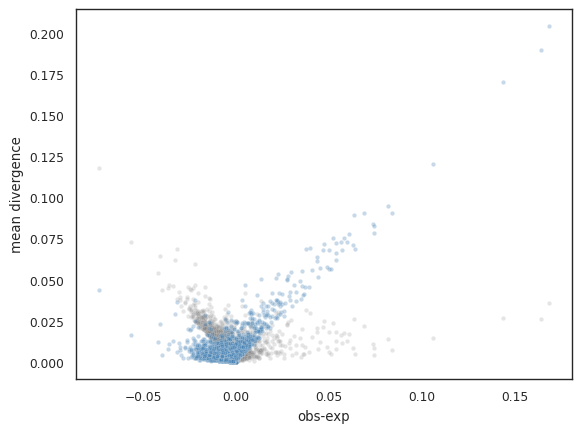

In [147]:
sns.scatterplot(x='obs-exp', y = 'exp_mean', data = distStats, color = 'grey', alpha=.2, s= 10)
sns.scatterplot(x='obs-exp', y = 'obs_mean', data = distStats, color='steelblue', alpha=.3, s=10)
plt.ylabel('mean divergence')

<AxesSubplot: xlabel='obs-exp', ylabel='exp_mean'>

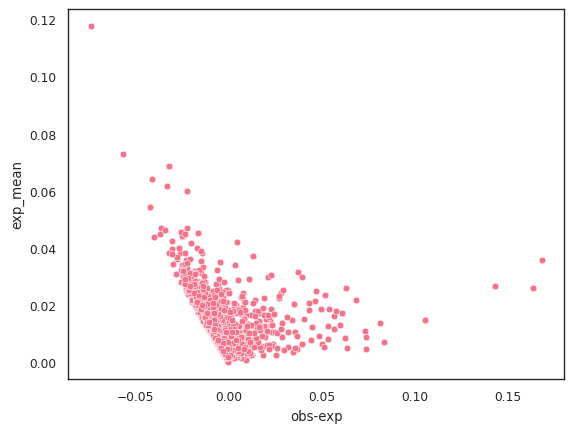

In [148]:
sns.scatterplot(x='obs-exp', y = 'exp_mean', data = distStats)

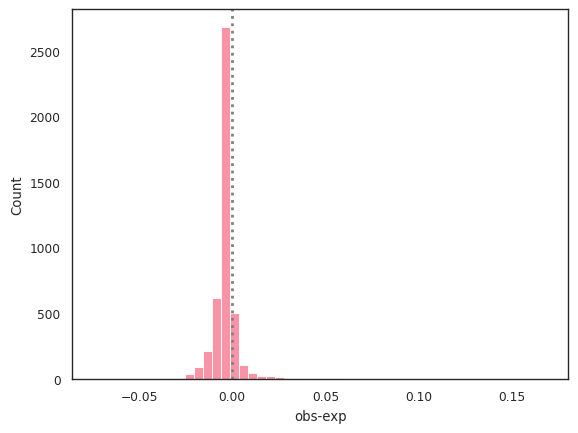

In [149]:
sns.histplot(distStats_sig['obs-exp'],bins=50 )
plt.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'grey') 

## Annotate deciles

In [150]:
def PercentileToQuantile(x, bins):
    numQuants = bins
    quantSize = 1/numQuants
    currentQuant = quantSize
    currentReturn = 1
    numDecs = int(str(quantSize)[::-1].find('.'))
    for i in range(numQuants):
        if x < currentQuant:
            return currentReturn
        elif x == 1:
            return numQuants
        else:
            currentQuant = round((currentQuant + quantSize), numDecs)
            currentReturn += 1


def QuantAnnotate(distStat_df, annot_data, annot_type, quant_bins, metric):
    regions = distStat_df.copy(deep=True)
    regions['divergence_percentile'] = regions[metric].rank(pct=True)
    regions = regions.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=quant_bins)
    regions['stop'] = regions['windowStartPos'] + 2**20
    regions = regions[['chr','windowStartPos','stop',metric,'divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group',metric]]

    if annot_type == 'genes':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='ctcf':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='phastCons':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','lod','phastCons_score','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','phastCons_score':'mean', 'divergence_percentile_group':'mean', metric:'mean'})
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='rmsk':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','repeat_type','repeat_score','strand','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','repeat_score':'mean', 'divergence_percentile_group':'mean', metric:'mean'})
        annotation_grouped= annotation_grouped.reset_index()
    return annotation_grouped, regions

In [151]:
# read in annotations
phastCons = pybedtools.BedTool('%s/annotations/phastConsElements100way_hg38.bed' % DATA_PATH)
ctcf = pybedtools.BedTool('%s/annotations/ctcf_all_hg38.bed' % DATA_PATH).merge()
rmsk = pybedtools.BedTool('%s/annotations/rmsk_hg38.bed' % DATA_PATH)
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)

OSError: [Errno 70] Communication error on send

In [107]:
distStats_more

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       ALL       AFR       EUR       EAS       SAS  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.011143  0.010108  0.011830  0.013180  0.011994   
      57147392        ...  0.021517  0.009149  0.031168  0.016713  0.022907   
      70778880        ...  0.003761  0.003670  0.003780  0.003793  0.003737   
      88604672        ...  0.014955  0.007492  0.022346  0.014407  0.018429   
      92798976        ...  0.071182  0.062220  0.047517  0.096720  0.079656   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030532  0.034489  0.028786  0.028111  0.029609   
chr22 22020096        ...  0.023887  0.027355  0.024776  0.021138  0.021943   
      22544384        ...  0.011776  0.015540  0.012083  0.008256  0.011551   
      47710208        ...  0.055388  0.055222  0.060998  0.053654  0.047932   
      48234496        ...  0.204145  0.204803  0.214279  0.197077  0.187644   

                           AMR       min       max   emp_min   emp_max  
chr   windowStartPos                                                    
chr1  41418752        0.008076  0.000214  0.061708  0.000240  0.047160  
      57147392        0.036207  0.000460  0.241914  0.000711  0.198873  
      70778880        0.003891  0.000125  0.015220  0.000125  0.071377  
      88604672        0.014783  0.000098  0.068938  0.000080  0.055810  
      92798976        0.074693  0.000381  0.260017  0.000371  0.454930  
...                        ...       ...       ...       ...       ...  
chr21 35127296        0.030236  0.008522  0.120146  0.001044  0.323117  
chr22 22020096        0.022474  0.001957  0.055087  0.001038  0.190579  
      22544384        0.009572  0.000380  0.032310  0.000370  0.141347  
      47710208        0.059584  0.001600  0.142327  0.001173  0.203276  
      48234496        0.219469  0.00

r2 =  0.010040043534481865 p = 0.047707009336487465


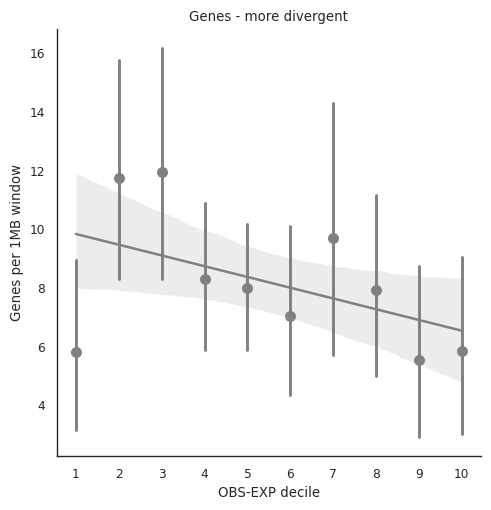

r2 =  0.010040043534481865 p = 0.047707009336487465


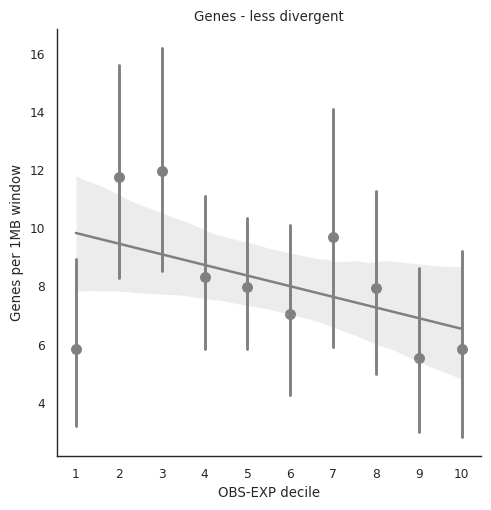

r2 =  0.04371678192990975 p = 5.694367773454832e-45


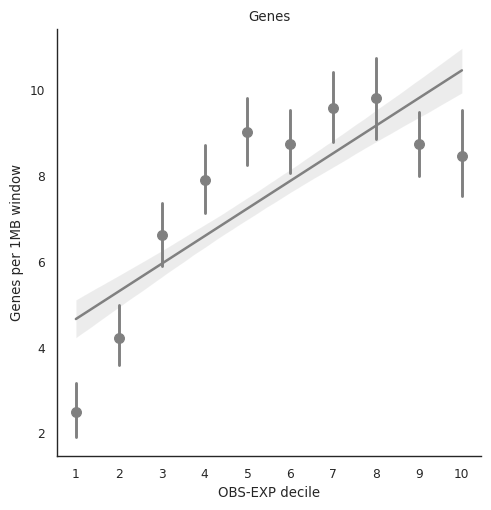

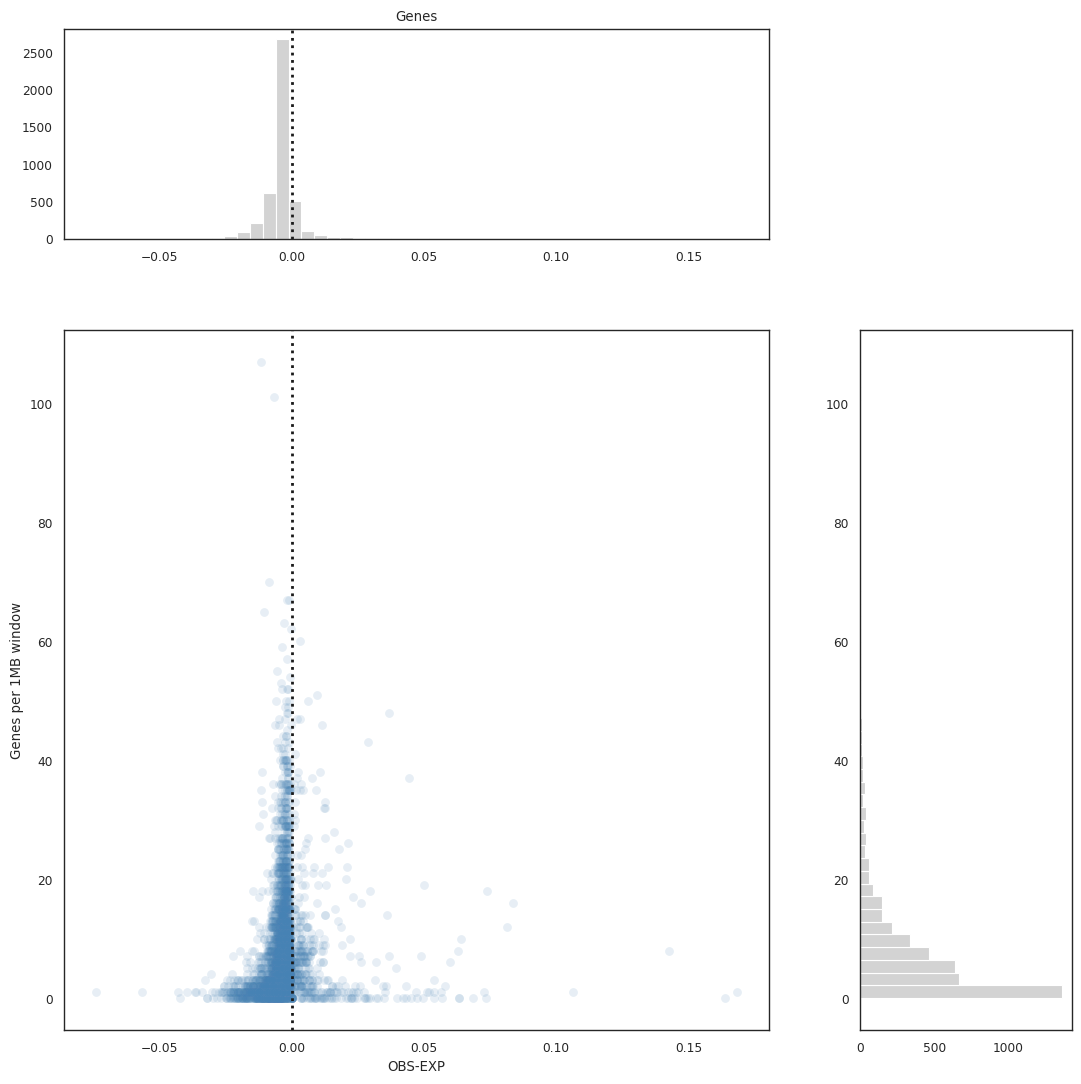

In [ ]:
#more divergent than expected
annotation, regions = QuantAnnotate(distStats_more, annot_data = genes, annot_type = 'genes', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='Genes - more divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()

#less divergent than expected
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='Genes - less divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()


# all significantly different than expected
annotation, regions = QuantAnnotate(distStats_sig, annot_data = genes, annot_type = 'genes', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='Genes')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# raw plot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(13,13),gridspec_kw={'width_ratios': [5, 1.5], 'height_ratios': [1.5, 5]})         # Sample figsize in inches
g = sns.scatterplot(x='obs-exp', y='annot_count', data=annotation, alpha=0.13, color='steelblue', ax=ax[1,0],linewidth=.05, s=40)#, x_bins=np.arange(0.9965,1,0.00025))  #scatter_kws={'s':2}
_ = g.set(xlabel="OBS-EXP", ylabel="Genes per 1MB window")
_ = g.set()
_ = g.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 


_ = ax[0,0].hist(annotation[['obs-exp']].values.flatten(),color='lightgray', bins=50)
_ = ax[0,0].axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 
_ = ax[0,0].set(title="Genes")
# _ = ax[0,0].set(xlim=(0, 0.0503))
# _ = ax[0,0].set( yticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], yticklabels=[0,"",.1,"",0.2], xticklabels='')


_ = ax[1,1].hist(annotation[['annot_count']].values.flatten(), orientation='horizontal', color='lightgray', bins=50)
# _ = ax[1,1].set(ylim=(0, 0.0503))
# _ = ax[1,1].set(xticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], xticklabels=[0,"",.1,"",0.2], yticklabels='')
ax[1,1].set()
ax[0, 1].axis('off')
plt.show()

r2 =  0.08433230525536937 p = 7.0423651811501115e-09
r2 =  0.11506187110869336 p = 2.2808936783680046e-109
r2 =  0.07559818951068968 p = 1.4350240349546748e-77


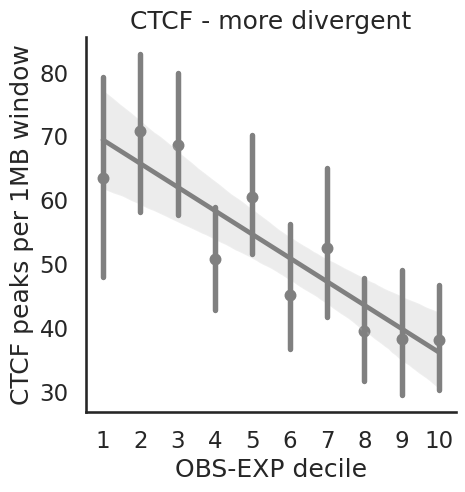

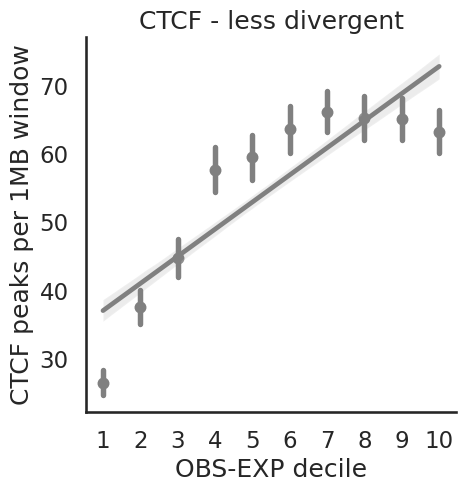

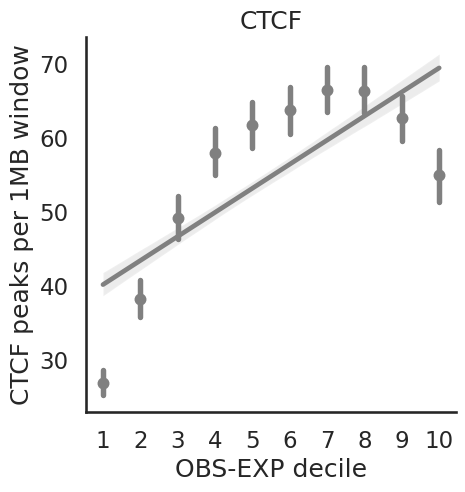

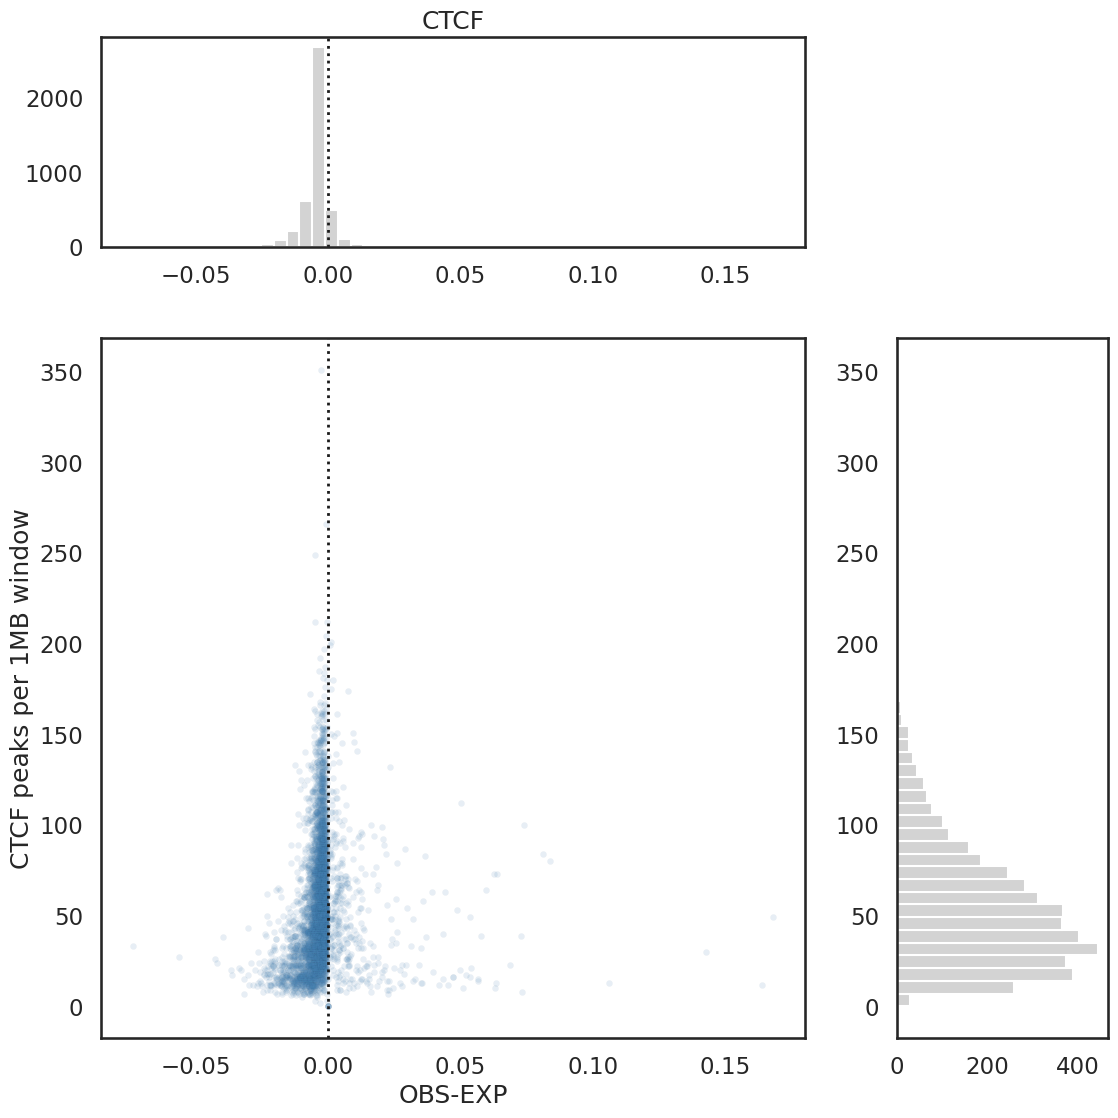

In [ ]:
#more
annotation, regions = QuantAnnotate(distStats_more, annot_data = ctcf, annot_type = 'ctcf', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="CTCF peaks per 1MB window", title='CTCF - more divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# less
annotation, regions = QuantAnnotate(distStats_less, annot_data = ctcf, annot_type = 'ctcf', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="CTCF peaks per 1MB window", title='CTCF - less divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# all
annotation, regions = QuantAnnotate(distStats_sig, annot_data = ctcf, annot_type = 'ctcf', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="CTCF peaks per 1MB window", title='CTCF')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(13,13),gridspec_kw={'width_ratios': [5, 1.5], 'height_ratios': [1.5, 5]})         # Sample figsize in inches
g = sns.scatterplot(x='obs-exp', y='annot_count', data=annotation, alpha=0.13, color='steelblue', ax=ax[1,0],linewidth=.05, edgecolor='k', s=20)#, x_bins=np.arange(0.9965,1,0.00025))  #scatter_kws={'s':2}
_ = g.set(xlabel="OBS-EXP", ylabel="CTCF peaks per 1MB window")
_ = g.set()
_ = g.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 


_ = ax[0,0].hist(annotation[['obs-exp']].values.flatten(),color='lightgray', bins=50)
_ = ax[0,0].axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 
_ = ax[0,0].set(title="CTCF")
# _ = ax[0,0].set(xlim=(0, 0.0503))
# _ = ax[0,0].set( yticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], yticklabels=[0,"",.1,"",0.2], xticklabels='')


_ = ax[1,1].hist(annotation[['annot_count']].values.flatten(), orientation='horizontal', color='lightgray', bins=50)
# _ = ax[1,1].set(ylim=(0, 0.0503))
# _ = ax[1,1].set(xticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], xticklabels=[0,"",.1,"",0.2], yticklabels='')
ax[1,1].set()
ax[0, 1].axis('off')
plt.show()

r2 =  0.04730959734550378 p = 1.752319759767904e-05
r2 =  0.04738882370062135 p = 1.5100963268760488e-44
r2 =  0.02605223593040659 p = 3.3108784174426085e-27


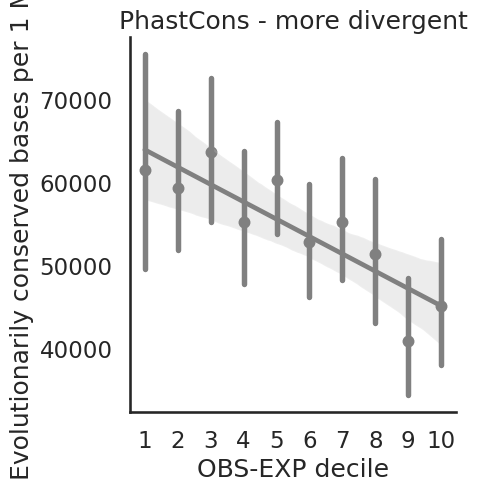

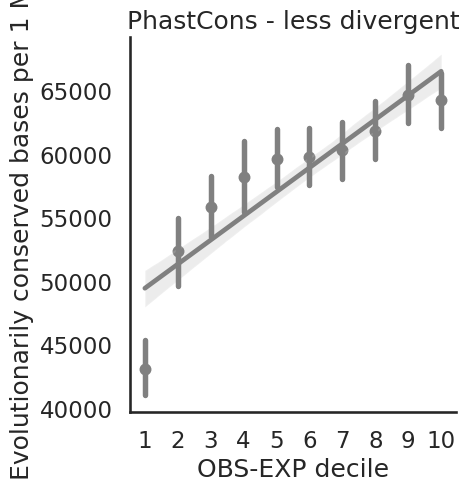

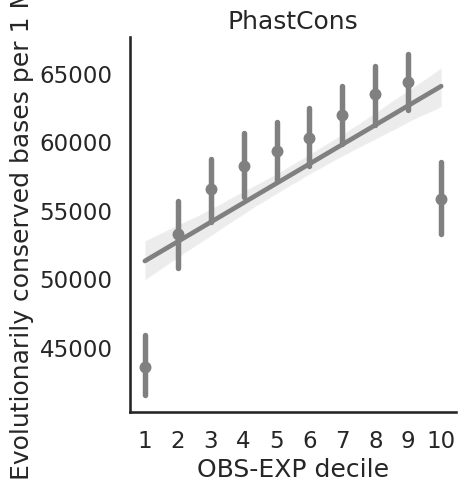

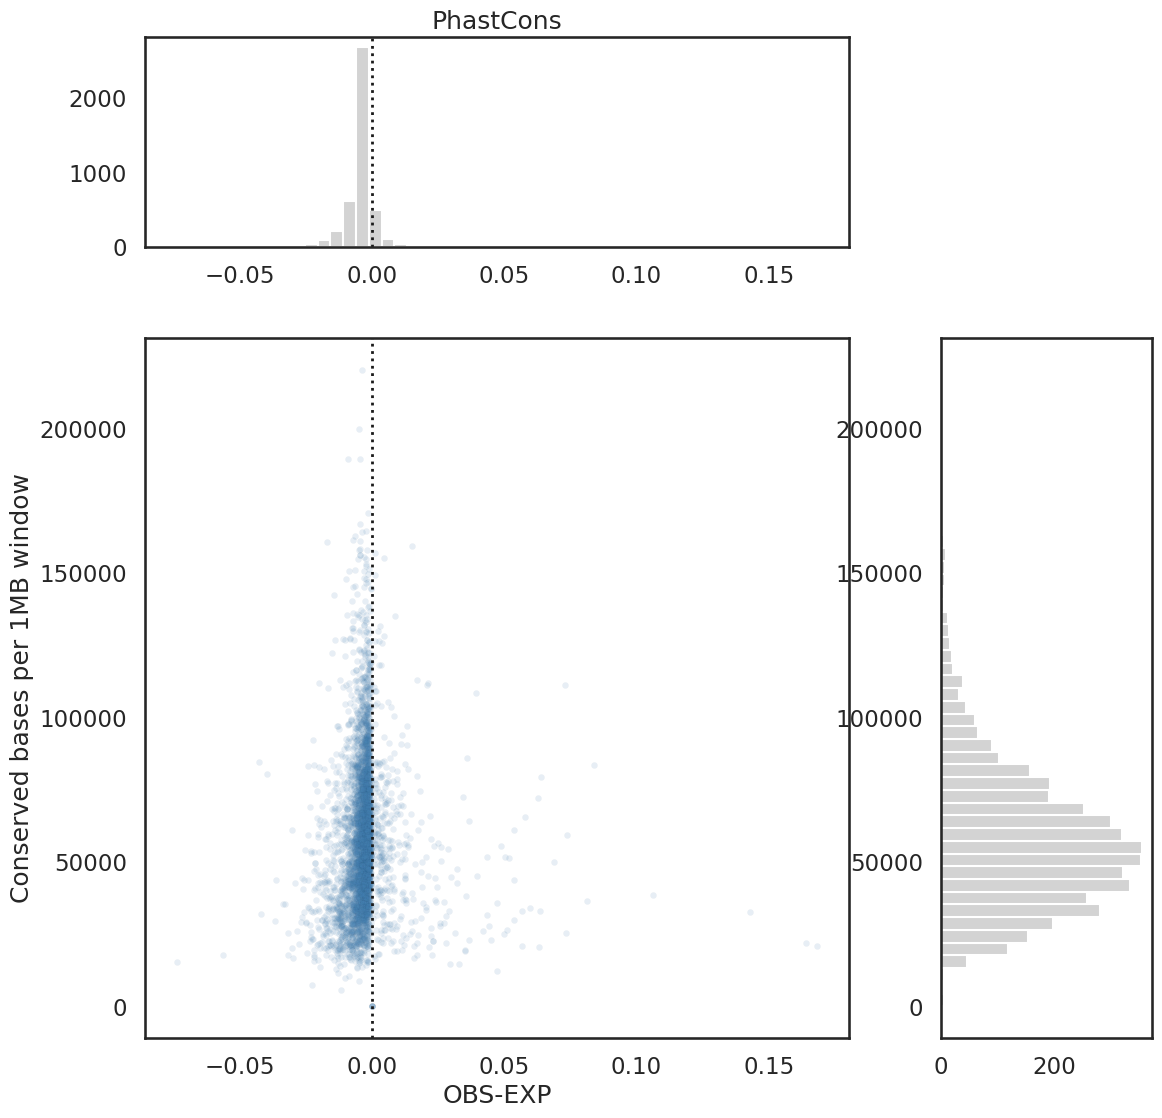

In [ ]:
# more
annotation, regions = QuantAnnotate(distStats_more, annot_data = phastCons, annot_type = 'phastCons', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Evolutionarily conserved bases per 1 MB", title='PhastCons - more divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# less
annotation, regions = QuantAnnotate(distStats_less, annot_data = phastCons, annot_type = 'phastCons', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Evolutionarily conserved bases per 1 MB", title='PhastCons - less divergent')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

# all
annotation, regions = QuantAnnotate(distStats_sig, annot_data = phastCons, annot_type = 'phastCons', quant_bins=10, metric = 'obs-exp')
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Evolutionarily conserved bases per 1 MB", title='PhastCons')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(13,13),gridspec_kw={'width_ratios': [5, 1.5], 'height_ratios': [1.5, 5]})         # Sample figsize in inches
g = sns.scatterplot(x='obs-exp', y='numBases', data=annotation, alpha=0.13, color='steelblue', ax=ax[1,0],linewidth=.05, edgecolor='k', s=20)#, x_bins=np.arange(0.9965,1,0.00025))  #scatter_kws={'s':2}
_ = g.set(xlabel="OBS-EXP", ylabel="Conserved bases per 1MB window")
_ = g.set()
_ = g.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 


_ = ax[0,0].hist(annotation[['obs-exp']].values.flatten(),color='lightgray', bins=50)
_ = ax[0,0].axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1, # Top of the plot
           ls = ':', lw = 2, color = 'k') 
_ = ax[0,0].set(title="PhastCons")
# _ = ax[0,0].set(xlim=(0, 0.0503))
# _ = ax[0,0].set( yticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], yticklabels=[0,"",.1,"",0.2], xticklabels='')


_ = ax[1,1].hist(annotation[['numBases']].values.flatten(), orientation='horizontal', color='lightgray', bins=50)
# _ = ax[1,1].set(ylim=(0, 0.0503))
# _ = ax[1,1].set(xticks=[0,.05*4873,.1*4873,.15*4873,.2*4873], xticklabels=[0,"",.1,"",0.2], yticklabels='')
ax[1,1].set()
ax[0, 1].axis('off')
plt.show()

### old, splitting populations

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([2085.5 , 2085.52, 2085.54, 2085.56, 2085.58, 2085.6 , 2085.62,
        2085.64, 2085.66, 2085.68, 2085.7 , 2085.72, 2085.74, 2085.76,
        2085.78, 2085.8 , 2085.82, 2085.84, 2085.86, 2085.88, 2085.9 ,
        2085.92, 2085.94, 2085.96, 2085.98, 2086.  , 2086.02, 2086.04,
        2086.06, 2086.08, 2086.1 , 2086.12, 2086.14, 2086.16, 2086.18,
        2086.2 , 2086.22, 2086.24, 2086.26, 2086.28, 2086.3 , 2086.32,
        2086.34, 2086.36, 2086.38, 2086.4 , 2086.42, 2086.44, 2086.46,
        2086.48, 2086.5 ]),
 <BarContainer object of 50 artists>)

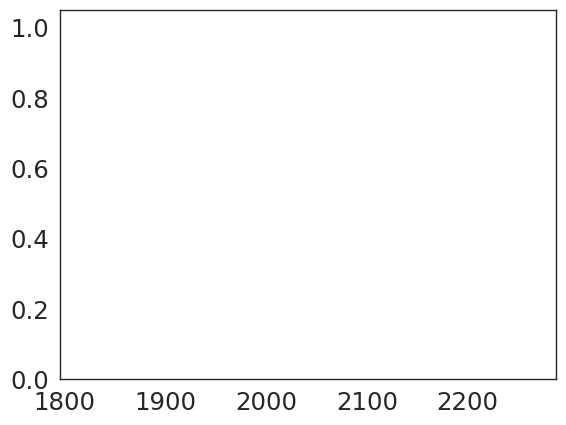

In [82]:
plt.hist(eDists['AFR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], bins = 50, alpha = 0.7)
plt.hist(eDists['AMR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], bins = 50, alpha = 0.7)
plt.hist(eDists['EUR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], bins = 50, alpha = 0.7)
plt.hist(eDists['EAS'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], bins = 50, alpha = 0.7)
plt.hist(eDists['SAS'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], bins = 50, alpha = 0.7)

In [83]:
kruskal = stats.kruskal(eDists['AFR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)], 
                  eDists['AMR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)],
                  eDists['EUR'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)],
                  eDists['EAS'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)],
                  eDists['SAS'].drop(columns=['num_diffs']).loc[( 'chr1',  1048576)])

In [84]:
kruskal

KruskalResult(statistic=4.0, pvalue=0.40600584970983794)

In [85]:
eDists_windows = dict.fromkeys(windows_to_keep)
weird_windows = []
weird_AFR = []
weird_AMR = []
weird_EUR = []
weird_EAS = []
weird_SAS = []

eDist_stats = pd.DataFrame(index = windows_to_keep, columns = ['kruskal','pval'])
for i in eDists_windows.keys():
    df = pd.DataFrame()
    try:
        df['AFR'] = eDists['AFR'].drop(columns=['num_diffs']).loc[i]
    except:
        weird_AFR.append(i)

    try:
        df['AMR'] = eDists['AMR'].drop(columns=['num_diffs']).loc[i]
    except:
        weird_AMR.append(i)

    try:
        df['EUR'] = eDists['EUR'].drop(columns=['num_diffs']).loc[i]
    except:
        weird_EUR.append(i)
        
    try:
        df['EAS'] = eDists['EAS'].drop(columns=['num_diffs']).loc[i]
    except:
        weird_EAS.append(i)

    try:
        df['SAS'] = eDists['SAS'].drop(columns=['num_diffs']).loc[i]
    except:
        weird_SAS.append(i)

    try:
        kruskal = stats.kruskal(df['AFR'], df['AMR'], df['EUR'], df['EAS'], df['SAS'])
        eDist_stats.loc[i] = kruskal
    except:
        weird_windows.append(i)
    eDists_windows[i] = df


In [86]:
eDist_stats[eDist_stats.pval < 0.05]

,,kruskal,pval
chr,windowStartPos,,


In [87]:
eDist_stats[eDist_stats.pval < (0.05/4873)]

,,kruskal,pval
chr,windowStartPos,,


In [88]:
len(weird_windows)

0

In [89]:
len(weird_AFR)

0

In [90]:
len(weird_AMR)

0

In [91]:
len(weird_EAS)

0

In [92]:
len(weird_SAS)

0

In [93]:
len(weird_EUR)

0

In [94]:
106+22+205

333

In [95]:
weird_pops = weird_AFR + weird_AMR + weird_EUR + weird_EAS + weird_SAS

In [96]:
for i in weird_windows:
    if i not in weird_pops:
        print(i)